#**Proyecto Final DSB2-2023 - Dataset: Online Retail Dataset**

Enlace de Dataset: https://www.kaggle.com/datasets/divanshu22/online-retail-dataset/data

Este conjunto de datos se refiere a las transacciones de ventas realizadas en línea de un comercio minorista de artículos de decoración para el hogar con accesorios de papelería y decorado para fiestas, entre otros artículos. Dichos registros contienen información sobre: clientes, número de factura, código de stock del artículo, descripción de los artículos comprados, cantidad de artículos en la compra, precio unitario del producto, fecha de la factura, identificación del cliente y país.

A continuación se muestra un desglose de las columnas del conjunto de datos:

- InvoiceNo: Un identificador único para cada transacción o factura.
- StockCode: Código que representa el stock o artículo comprado.
- Description: Una descripción textual del artículo comprado.
- Quantity: La cantidad del artículo comprado en cada transacción.
- InvoiceDate: la fecha y hora en que se produjo la transacción.
- UnitPrice: El precio por unidad del artículo comprado.
- CustomerID: el identificador único del cliente que realiza la compra.
- Country: El país donde se realizó la transacción.



El conjunto de datos contiene 542.000 registros. Los tipos de datos incluyen números enteros, flotantes, objetos de fecha y hora y cadenas.

Este conjunto de datos proporciona información valiosa sobre el comportamiento de compra de los clientes, la popularidad de los artículos, las tendencias de ventas a lo largo del tiempo y la distribución geográfica de las transacciones.

# **Limpieza y preprocesamiento de Datos**

## Pasos:

### 1.   Cargar datos
### 2.   Determinar y eliminar filas no relevantes
### 3.   Limpieza str 'Description' y selección de produtos
### 4.   Creación de nuevas columnas: LineTotal, InvoiceFecha, InvoiceHora, ProductId
### 5.   Creación de categorías de productos
### 6.   Exportación de Datos


### **1.   Cargar datos**

In [ ]:
# Se instala implicit para el modelo del sistema de recomendación
!pip install implicit

#Se importan las librerías necesarias
import pandas as pd
import datetime as dt
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import sys
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import random
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import plotly.express as px
import datetime as dt
import calendar
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import pickle
from IPython.display import Image
import joblib
from joblib import dump, load
import implicit

# Montar drive para cargar la base de datos
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 18.1 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
# Cambiar aquí el directorio donde se encuentran los archivos
dirBase = "/content/drive/MyDrive/Projecto_Senpai/EntregaFinal_Senpai/"

In [ ]:
#Carga de los datos
df = pd.read_excel(dirBase + "customer.xlsx")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


El df contiene 541.909 filas\
Solo presenta nulos en CustomerID

### **2.   Determinar y eliminar filas no relevantes**

*   Se eliminan los elementos con UnitPrice <= 0
*   Se eliminan los elementos con Quantity <= 0
*   Se eliminan los StockCode 'POST' y 'DOT', ya que no corresponden a productos
*   Se eliminan los elementos con Country 'Unspecified'



In [ ]:
df.drop(df[df['UnitPrice']<= 0].index , inplace = True)
df.drop(df[df['Quantity']<= 0].index , inplace = True)
df.drop(df[df['StockCode']== 'POST'].index , inplace = True)
df.drop(df[df['StockCode']== 'DOT'].index , inplace = True)
df.drop(df[df['Country']== 'Unspecified'].index , inplace = True)

In [ ]:
len(df)

527826

Se conservan 527.826 filas\
97,4% del data frame original

- Se cambian datos en Country RSA = South Africa y EIRE = Ireland

In [ ]:
paises = {
    "RSA": "South Africa",
    "EIRE": "Ireland",
}

df['Country'] = df['Country'].replace(paises)

### **3.   Limpieza str 'Description' y selección de produtos**

Para un correcto procesamiento posterior de la columna 'Description' se realizan varios pasos:
- Sustituir los símbolos, +, -, -, . y / por espacios
- Eliminar los espacios dobles
- Eliminar espacios al inicio y al final del str

In [ ]:
#Cambiar + y - por espacio
df['Description'] = df['Description'].str.replace('.', ' ')
df['Description'] = df['Description'].str.replace('+', ' ')
df['Description'] = df['Description'].str.replace('-', ' ')
df['Description'] = df['Description'].str.replace(',', ' ')
#Cambiar / por espacio
df['Description'] = df['Description'].str.replace('/', ' ')
# Elimina los espacios dobles
df['Description'] = df['Description'].str.replace('  ', ' ')
df['Description'] = df['Description'].str.replace('  ', ' ')
df['Description'] = df['Description'].str.replace('  ', ' ')
df['Description'] = df['Description'].str.replace('  ', ' ')
# Elimina los espacios al inicio y al final de cada valor en la columna "Description"
df['Description'] = df['Description'].str.strip()

In [ ]:
df['Description'].nunique()

3988



*   Tenemos 3.988 Descripciones (productos) diferentes



Se busca minimizar la cantidad de productos para facilitar su posterior clasificación en categorías, a la vez que se mantiene una cantidad suficiente de filas para el posterior análisis (aproximadamente 300.000).\
*Para esto se eliminan los productos que tengan menos de 250 repeticiones*

In [ ]:
#Se analiza las repeticiones de las descripciones (compras) y nos quedamos solo con los productos que tengan al menos 250 compras

#Data frame con Descriptions y cantidad de repeticiones
descripciones = df['Description'].tolist()
frecuencia = Counter(descripciones)
df_descripciones = pd.DataFrame({
    'Description': list(frecuencia.keys()),
    'Quantity': list(frecuencia.values())
})
df_descripciones = df_descripciones.sort_values('Quantity', ascending=False)

#Elegir solamente las descripciones con +250 repeticiones y eliminar de df
df_descripciones_filtrado = df_descripciones.loc[df_descripciones['Quantity'] <= 250]
descripciones_a_eliminar = df_descripciones_filtrado['Description'].tolist()
df = df.loc[~df['Description'].isin(descripciones_a_eliminar)]

Al analizar nuevamente las descripciones restantes, se identifica una categoría 'Manual' que no se corresponde a un producto.\
Se eliminan las filas de dicha descripción.

In [ ]:
# Limpiamos los productos tipo Manual, que no son productos.
df = df.query('Description != "Manual"')

In [ ]:
print(df['Description'].nunique())
print(len(df))

611
298447


Finalmente se conservan 611 productos, que se repiten más de 250 veces cada uno y 298.447 filas\
55,1% del data frame original

### **4.   Creación de nuevas columnas: LineTotal, InvoiceFecha, InvoiceHora, ProductId**



*   Creamos la columna Line Total, para saber el monto (gasto) total de cada fila



In [ ]:
#Multiplicamos los valores de las columnas de cantidad por los valores de la columna precio unitario de los productos y los almacenamos en la columna 'InvoiceTotal'
df['LineTotal'] = df['Quantity'] * df['UnitPrice']

<ipython-input-13-c67ccea483d6>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy





*   La información en 'InvoiceDate' la dividiremos en dos columnas, 'InvoiceFecha' e 'InvoiceHora', para poder utilizar dicha información por separado en el análisis


In [ ]:
#Separamos la fecha y la hora de la columna 'InvoiceDate' a las columnas 'InvoiceFecha' e 'InvoiceHora' respectivamente
df['InvoiceFecha'] = df['InvoiceDate'].dt.date
df['InvoiceHora'] = df['InvoiceDate'].dt.time

# Definimos el tipo de campo InvoiceFecha en datetime64[ns]
df['InvoiceFecha'] = pd.to_datetime(df['InvoiceFecha'])

#Eliminamos la columna 'InvoiceDate'
df = df.drop('InvoiceDate', axis = 1)

<ipython-input-14-4b5a504ad2a4>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Generamos los días de la semana codificados para usarlos en el análisis exploratorio posterior.



In [ ]:
#Monday is 0 and Sunday is 6
df['InvoiceDiaSemana'] = df['InvoiceFecha'].dt.dayofweek

In [ ]:
#Validación, solo tienen que aparecer valores del 0 al 6. Los sabados está cerrado por eso el 5 no está presente.
df['InvoiceDiaSemana'].unique()

array([2, 3, 4, 6, 0, 1], dtype=int32)

Generamos una columna con el valor de la hora en que se realiza la compra, para hacer análisis posterior. Se eliminan los minutos y segundos


In [ ]:
df['InvoiceHora'] = pd.to_datetime(df['InvoiceHora'], format='%H:%M:%S')
df['Hora'] = df['InvoiceHora'].dt.hour

#eliminamos la columna original de hora
df = df.drop('InvoiceHora', axis = 1)

Eliminamos la columna StockCode, con el fin de asignarle un nuevo código a cada artículo posteriormente a su clasificación y selección. El valor StockCode original no esta correcto como una clave única de producto, sino que es una combinación de letras y números, donde se encontraron algunos problemas como sensibilidad a las mayusculas y minusculas para describir productos diferentes. Optamos por recodificar con una clave numérica única para cada producto.

In [ ]:
#Eliminamos la columna 'StockCode'
df = df.drop('StockCode', axis = 1)

In [ ]:
#Crearmos columna Category y Stock Id
df['Category'] = df['Description']
df['ProductId'] = df['Description']

In [ ]:
#generar codigos de ID para los productos y cargarlos en la tabla ProductId y reemplazar el nombre del producto por su id como en categoria
valores_unicos_Id = df['Description'].unique().tolist()
Id = 1
for val in valores_unicos_Id:
  df['ProductId'] = df['ProductId'].replace(val, str(Id))
  Id +=1

In [ ]:
#verificación, tienen que aparecer todos los numeros desde el 1 al 611
print(df['ProductId'].unique())

['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30'
 '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43' '44'
 '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55' '56' '57' '58'
 '59' '60' '61' '62' '63' '64' '65' '66' '67' '68' '69' '70' '71' '72'
 '73' '74' '75' '76' '77' '78' '79' '80' '81' '82' '83' '84' '85' '86'
 '87' '88' '89' '90' '91' '92' '93' '94' '95' '96' '97' '98' '99' '100'
 '101' '102' '103' '104' '105' '106' '107' '108' '109' '110' '111' '112'
 '113' '114' '115' '116' '117' '118' '119' '120' '121' '122' '123' '124'
 '125' '126' '127' '128' '129' '130' '131' '132' '133' '134' '135' '136'
 '137' '138' '139' '140' '141' '142' '143' '144' '145' '146' '147' '148'
 '149' '150' '151' '152' '153' '154' '155' '156' '157' '158' '159' '160'
 '161' '162' '163' '164' '165' '166' '167' '168' '169' '170' '171' '172'
 '173' '174' '175' '176' '177' '178' '179' '180' '181' '182' '1

### **5.   Creación de categorías de productos**



> Para el procesamiento de las categorías de productos se utiliza una planilla que contiene los datos que vinculan a las categorías de productos y los productos.
Luego se agregan dichas categorías a los corresponidentes productos en el data frame de trabajo.
Para eso, se copia la columna de descripción de productos y luego se reemplaza por la descrición de la categoría.




In [ ]:
#Leemos la planilla con las categorias y productos
df_categorias = pd.read_excel(dirBase + "categorias.xlsx")

In [ ]:
#Armamos una estructura de datos que contiene la categoria y todos los productos de esa categoría
resultado = []

for column in df_categorias:
  resultado.append([df_categorias[column].name, df_categorias[column].values])

In [ ]:
#Por cada categoría, recorro los productos asociados y se va reemplazando los nombres de los productos por su categoría correspondiente
for CatList in resultado:
  Categoria = str(CatList[0]).strip()
  ListaProducto = CatList[1]

  for p in ListaProducto: #reemplazo el valor por la categoría
    if not pd.isna(p) :
      pstr = str(p).strip()
      df['Category'] = df['Category'].replace(to_replace=pstr, value=Categoria, regex=False)

In [ ]:
#Verificación, solo tienen que aparecer nombres de categorías y ningun nombre de producto.
print(df['Category'].unique())

['Homeware' 'Room decor' 'Office supplies' 'Kitchen tools'
 'Home appliances' 'Bathroom amenities' 'Electronics'
 'Kids and baby stuff' 'Books and stationery' 'Garden and outdoor'
 'Pet products' 'Clothing' 'Accessories' 'Food and drinks' 'Personal care'
 'Jewelry' 'Health and fitness']


Se sumarizan las facturas para generar el monto total de la factura y la cantidad de productos comprados en la factura.

In [ ]:
#Luego se integran ambas columnas al data frame
df_nuevo = df.groupby('InvoiceNo').agg(TotalQuantity=pd.NamedAgg(column='Quantity', aggfunc='sum'), TotalAmount=pd.NamedAgg(column='LineTotal', aggfunc='sum'))

df = df.join(df_nuevo, on='InvoiceNo', how='left')

Modelo de datos finalmente generado.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 298447 entries, 0 to 541908
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         298447 non-null  object        
 1   Description       298447 non-null  object        
 2   Quantity          298447 non-null  int64         
 3   UnitPrice         298447 non-null  float64       
 4   CustomerID        232939 non-null  float64       
 5   Country           298447 non-null  object        
 6   LineTotal         298447 non-null  float64       
 7   InvoiceFecha      298447 non-null  datetime64[ns]
 8   InvoiceDiaSemana  298447 non-null  int32         
 9   Hora              298447 non-null  int32         
 10  Category          298447 non-null  object        
 11  ProductId         298447 non-null  object        
 12  TotalQuantity     298447 non-null  int64         
 13  TotalAmount       298447 non-null  float64       
dtypes: dateti

### **6.   Exportación de datos**

Exportamos los datos a un archivo tipo .xlsx (Excel).

In [ ]:
#Se genera el archivo procesado para el uso del resto del procesamiento
df.to_excel(dirBase + "customer_procesado.xlsx")

# **Análisis Exploratorio de Datos (EDA)**

Se realizará el análisis exploratorio de datos por los **14 atributos** que contiene el dataset y las **298.447** filas que resultaron del procesamiento de los datos.\
Los atributos con que cuenta el dataset son:
*   InvoiceNo (int64)-------------------------Nro de factura
*   Description (object)---------------------Descripción del producto comprado        
*   Quantity (int64)----------------------------Cantidad de unidades compradas del producto         
*   UnitPrice (float64)------------------------Valor de la unidad comprada       
*   CustomerID (float64)-------------------ID del cliente (       
*   Country (object)---------------------------País del que se realiza la compra        
*   LineTotal (float64)-----------------------Gasto total (Quantity * UnitPrice)       
*   InvoiceFecha (datetime64[ns])----Fecha de la compra (dd/mm/aaaa)
*   Category (object)-------------------------Categoría a la que pertenece el producto comprado (17 categorías)        
*   ProductId (int64)-------------------------ID del producto (611 IDs)
*   InvoiceDiaSemana (int64)-----------Día de la semana realizada la compra (0 - Lunes a 6 - Domingo)         
*   Hora (int64)---------------------------------Hora realizada la compra (hh)         
*   TotalQuantity (int64)-------------------Cantidad de productos comprados en la factura correspondiente         
*   TotalAmount (int64)--------------------Gasto total de la facutra


**Cargar datos**

In [ ]:
df_carga = pd.read_excel(dirBase + "customer_procesado.xlsx")
df = df_carga.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298447 entries, 0 to 298446
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Unnamed: 0        298447 non-null  int64         
 1   InvoiceNo         298447 non-null  int64         
 2   Description       298447 non-null  object        
 3   Quantity          298447 non-null  int64         
 4   UnitPrice         298447 non-null  float64       
 5   CustomerID        232939 non-null  float64       
 6   Country           298447 non-null  object        
 7   LineTotal         298447 non-null  float64       
 8   InvoiceFecha      298447 non-null  datetime64[ns]
 9   InvoiceDiaSemana  298447 non-null  int64         
 10  Hora              298447 non-null  int64         
 11  Category          298447 non-null  object        
 12  ProductId         298447 non-null  int64         
 13  TotalQuantity     298447 non-null  int64         
 14  Tota

In [ ]:
# Encontrar la fecha máxima y mínima
fecha_maxima = df['InvoiceFecha'].max()
fecha_minima = df['InvoiceFecha'].min()

# Imprimir los resultados (con formato opcional)
print("Fecha máxima:", fecha_maxima.strftime("%Y-%m-%d"))
print("Fecha mínima:", fecha_minima.strftime("%Y-%m-%d"))

Fecha máxima: 2011-12-09
Fecha mínima: 2010-12-01


# **Análisis por países**

In [ ]:
# Obtener los valores únicos y su cantidad
valores_unicos = df.Country.unique()
cantidad = df.Country.nunique()

print(f"Nombres de los países que realizaron compras: {valores_unicos}")
print(f"Cantidad de países: {cantidad}")

Nombres de los países que realizaron compras: ['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'Ireland' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Finland' 'Austria' 'Sweden' 'Israel' 'Greece' 'Hong Kong' 'Singapore'
 'Lebanon' 'United Arab Emirates' 'Saudi Arabia' 'Czech Republic' 'Canada'
 'Brazil' 'USA' 'European Community' 'Bahrain' 'Malta' 'South Africa']
Cantidad de países: 37


Se han realizado compras desde 36 paises y la Comunidad Europea, con representación de todos los continentes.\
- 22 paises Europeos
- 14 paises de otros continentes

## **País vs Gasto total (USD)**

In [ ]:
countries = df.groupby('Country')['LineTotal'].sum()
data = dict(type='choropleth', locations=countries.index, locationmode='country names', z=countries, text=countries.index, colorbar={'title': 'Invoice #'})
layout = dict(title='Gasto por país', geo=dict(showframe=True, projection={'type': 'mercator'}), width=1000, height=1000)
choromap = go.Figure(data=[data], layout=layout)
iplot(choromap, validate=False)

Top 10 Countries:
Country
United Kingdom    5701348.73
Netherlands        200154.40
Ireland            166869.65
Germany            129804.26
France             124912.59
Australia           91490.25
Spain               33652.61
Switzerland         31943.62
Japan               25212.11
Belgium             24549.21
Name: LineTotal, dtype: float64


Gasto total: 6680592.010000001




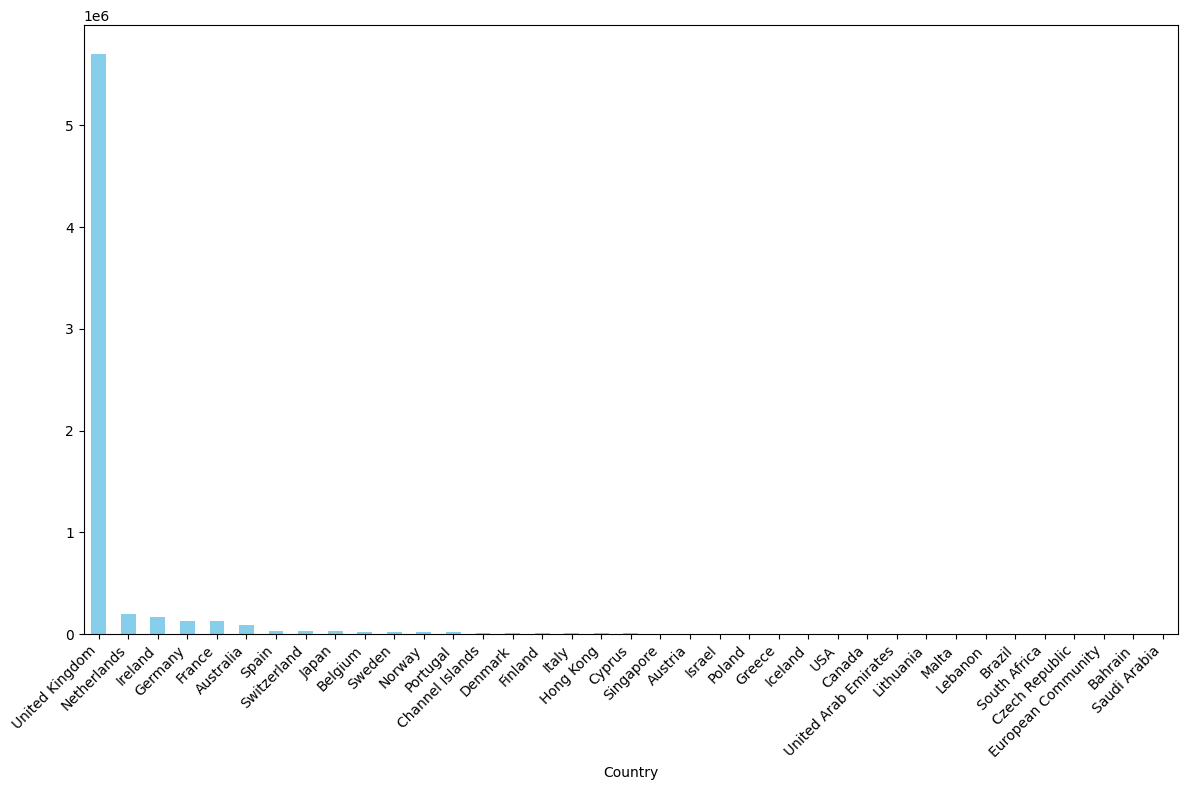

In [ ]:
#Análisis por costo total (USD/EUR?) de compras
gasto_paises = df.groupby('Country')['LineTotal'].sum().sort_values(ascending=False)

# Top 10 paises con gastos
top_10_countries = gasto_paises.head(10)
print("Top 10 Countries:")
print(top_10_countries)
print('\n')
suma_total = df['LineTotal'].sum()
print(f"Gasto total: {suma_total}" )
print('\n')

plt.figure(figsize=(12, 8))
gasto_paises.plot(kind='bar', color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

UK representa más del 85% del gasto realizado en el ratil

## País vs Gasto total (USD) SIN UK

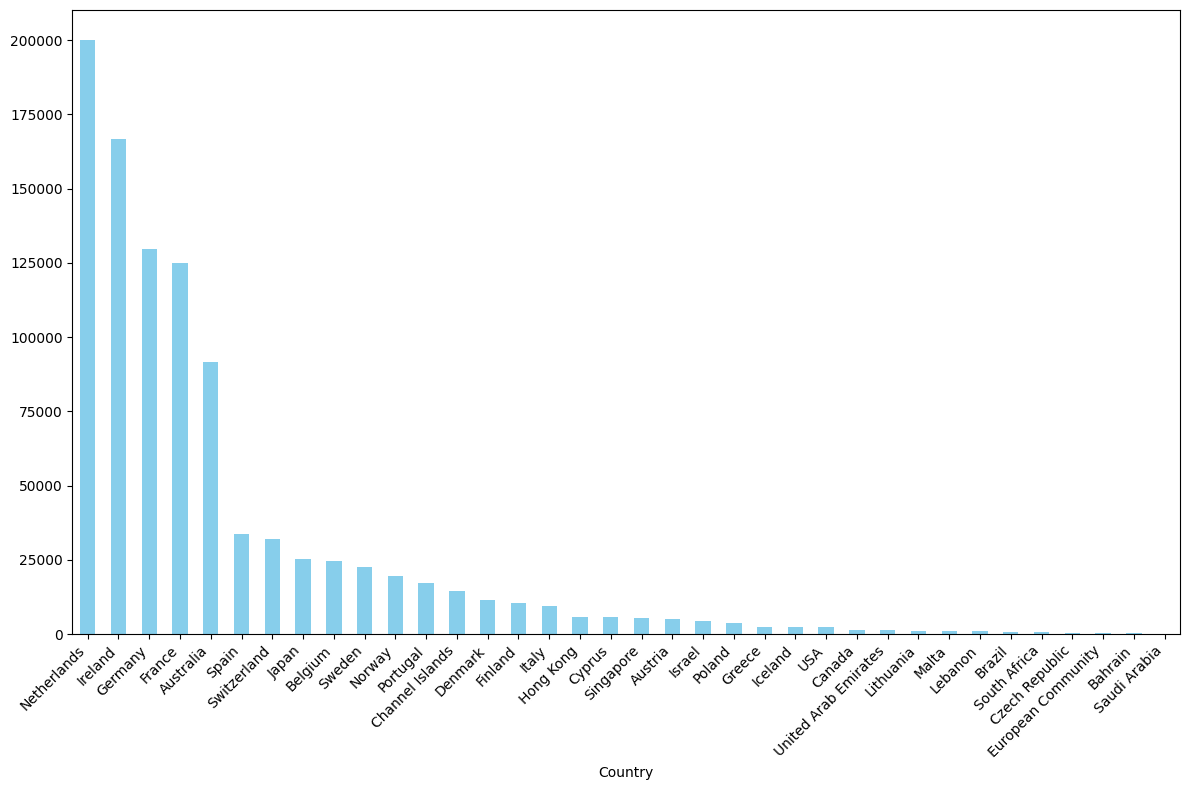

In [ ]:
#Distribución de los paises sin contar United Kindom
df_sin_uk = df[df['Country'] != 'United Kingdom']
gasto_paises2 = df_sin_uk.groupby('Country')['LineTotal'].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
gasto_paises2.plot(kind='bar', color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## **País - Gasto total - Cantidad de compras**

In [ ]:
#Análisis por cantidad (#) de compras

## Revisar agrupar por factura, luego por país y count
facturas_paises = df.groupby('Country')['InvoiceNo'].count().sort_values(ascending=False)

suma_total = df['InvoiceNo'].count()
print(f"Facturas totales: {suma_total}" )
print('\n')


# Top 10 paises con cantidad de compras
top_10_countries = facturas_paises.head(10)

# Unir gasto por paises y # de compras
df2 = pd.merge(gasto_paises, facturas_paises, on="Country")
df_primeros_10 = df2[:10]
df_primeros_10 = df_primeros_10.rename(columns={"InvoiceNo": "Cantidad de facturas"})
df_primeros_10 = df_primeros_10.rename(columns={"LineTotal": "Monto Total"})
df_primeros_10

Facturas totales: 298447




,Monto Total,Cantidad de facturas
Country,,
United Kingdom,5701348.73,272949
Netherlands,200154.40,1486
Ireland,166869.65,4448
Germany,129804.26,5108
France,124912.59,5080
Australia,91490.25,716
Spain,33652.61,1360
Switzerland,31943.62,1041
Japan,25212.11,162


Uniendo UK, Netherlands, Ireland, Germany y France:


*   Gasto es más de 94,6% del total
*   Las facturas son más del 96,8%



Graficamos la relación entre Monto total gastado por país y la cantidad de facturas, para los 9 paises con mayor gasto (se excluye UK)

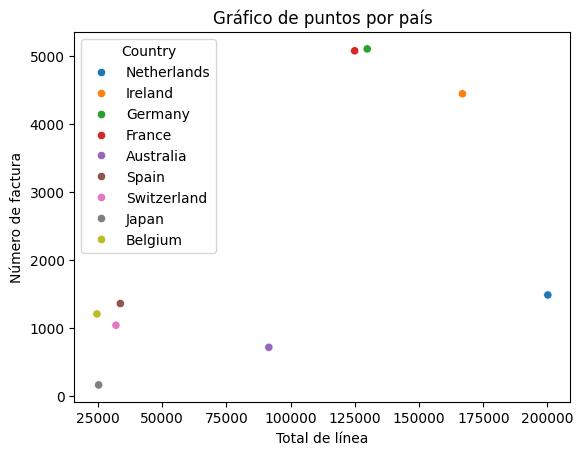

In [ ]:
# Crea el scatter plot con Seaborn
df_sin_uk = df_primeros_10[1:]
sns.scatterplot(data=df_sin_uk, x="Monto Total", y="Cantidad de facturas", hue="Country")

# Ajustar el gráfico
plt.title("Gráfico de puntos por país")
plt.xlabel("Total de línea")
plt.ylabel("Número de factura")
plt.show()

## **Análisis por Descripción**

In [ ]:
# Agrupar por descripción y calcular total de cantidad vendida
most_sold_items = df.groupby(['Description'])['Quantity'].sum().reset_index()
most_sold_items = most_sold_items.sort_values(by=["Quantity"], ascending=False)

# Gráfico de barras
fig = px.bar(most_sold_items.head(10), x='Description', y='Quantity', color='Quantity', title="Artículos más vendidos (en Unidades)",)
fig.update_xaxes(title="Item Description")
fig.update_yaxes(title="Unidades")
fig.show()

In [ ]:
# Agrupar por descripción y calcular total de cantidad recaudada
most_sold_items = df.groupby(['Description'])['LineTotal'].sum().reset_index()
most_sold_items = most_sold_items.sort_values(by=["LineTotal"], ascending=False)

# Gráfico de barras
fig = px.bar(most_sold_items.head(10), x='Description', y='LineTotal', color='LineTotal', title="Artículos que más recauda",)
fig.update_xaxes(title="Item Description")
fig.update_yaxes(title="Total Revenue")
fig.show()

## **Artículos más comprados por país**

In [ ]:
#Artículos más comprados por país
art_pais = df.groupby(['Country', 'Description'])['Quantity'].sum().sort_values(ascending=False)
art_pais = pd.DataFrame(art_pais, columns=['Quantity'])
art_pais = art_pais.reset_index()

In [ ]:
def obtener_articulos_mas_vendidos(df):
  # Crear un nuevo DataFrame vacío
  resultado = pd.DataFrame(columns=['Country', 'Description', 'Quantity'])

  countries = df['Country'].unique()
  for country in countries:
    df2 = df[df['Country'] == country]
    cantidad_max = df2['Quantity'].max()
    filtrado = df2.loc[df2['Quantity'] == cantidad_max]
    resultado = pd.concat([resultado, filtrado], ignore_index=True)

  return resultado

In [ ]:
art_mas_vendido = obtener_articulos_mas_vendidos(art_pais)
print(art_mas_vendido.head(10))

          Country                         Description Quantity
0  United Kingdom   WORLD WAR 2 GLIDERS ASSTD DESIGNS    49526
1     Netherlands                  RABBIT NIGHT LIGHT     4801
2          France                  RABBIT NIGHT LIGHT     4024
3           Japan                  RABBIT NIGHT LIGHT     3408
4       Australia              MINI PAINT SET VINTAGE     2952
5          Sweden              MINI PAINT SET VINTAGE     2916
6         Ireland     PACK OF 72 RETROSPOT CAKE CASES     1800
7         Germany  ROUND SNACK BOXES SET OF4 WOODLAND     1233
8           Spain     CHILDRENS CUTLERY POLKADOT PINK      729
9     Switzerland    PLASTERS IN TIN WOODLAND ANIMALS      639


## Artículos más vendidos en UK

In [ ]:
art_uk = art_pais[art_pais['Country'] == 'United Kingdom']
art_uk.head(10)

,Country,Description,Quantity
0,United Kingdom,WORLD WAR 2 GLIDERS ASSTD DESIGNS,49526
1,United Kingdom,JUMBO BAG RED RETROSPOT,44264
2,United Kingdom,WHITE HANGING HEART T LIGHT HOLDER,35740
3,United Kingdom,POPCORN HOLDER,34738
4,United Kingdom,ASSORTED COLOUR BIRD ORNAMENT,33735
5,United Kingdom,PACK OF 12 LONDON TISSUES,25127
6,United Kingdom,PACK OF 72 RETROSPOT CAKE CASES,24986
7,United Kingdom,VICTORIAN GLASS HANGING T LIGHT,23692
8,United Kingdom,ASSORTED COLOURS SILK FAN,21066
9,United Kingdom,PACK OF 60 PINK PAISLEY CAKE CASES,20365


## **Categorías y paises**

El objetivo es obtener las 5 categorías más vendidas en cada uno de los 10 paises que tienen mayor cantidad de ventas

In [ ]:
#Tomamos los 10 paises con mayor cantidad de ventas
top_countries_names = top_10_countries.index.tolist()
df_filtered = df[df['Country'].isin(top_countries_names)]

#Categoría más vendida por país
grouped_df = df_filtered.groupby(["Country", "Category"])
count_df = grouped_df.size().to_frame(name="#")
cat_pais = count_df.reset_index()
cat_pais = pd.DataFrame(cat_pais)
cat_pais_sorted = cat_pais.sort_values(by=["Country", "#"], ascending=[True, False])
cat_pais_sorted.reset_index(drop=True, inplace=True)

In [ ]:
def countar_ocurrencias(df, column, text):
    count = 0
    for i in range(len(df)):
        if df[column].iloc[i] == text:
            count += 1
    return count

In [ ]:
def obtener_categorias_mas_vendidas(df,num):
  # Crear un nuevo DataFrame vacío
  resultado = pd.DataFrame(columns=['Country', 'Category', '#'])

  for i in range(len(df)):
    pais = df.loc[i, 'Country']
    occurrencias = countar_ocurrencias(resultado, "Country", pais)
    if occurrencias < num:
      nuevo_pais = pd.Series({
          'Country': pais,
          'Category': df.loc[i, 'Category'],
          '#': df.loc[i, '#']
      }).to_frame().T
      resultado = pd.concat([resultado, nuevo_pais], ignore_index=True)

  return resultado

### **10 Categorías más vendidas en UK**

In [ ]:
cat_uk = cat_pais_sorted[cat_pais_sorted['Country'] == 'United Kingdom']
cat_uk.reset_index(drop=True, inplace=True)
cat_mas_vendidas = obtener_categorias_mas_vendidas(cat_uk,10)

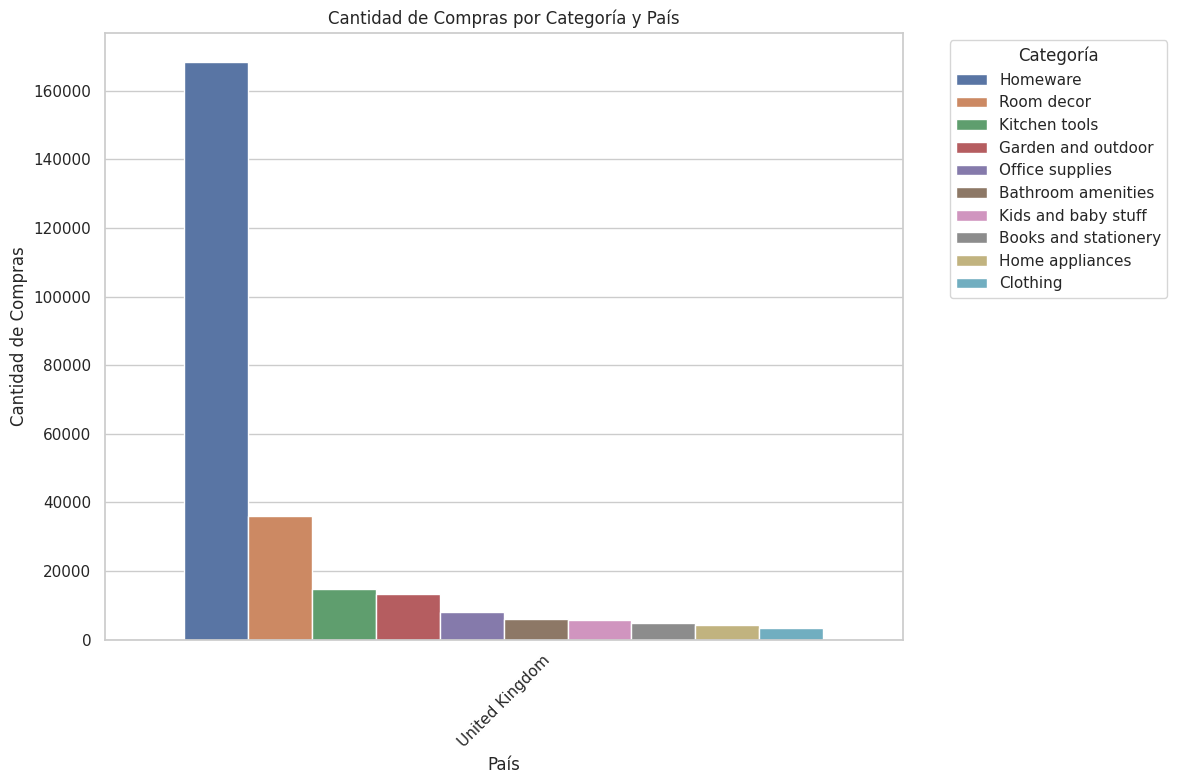

In [ ]:
# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear el gráfico de barras
plt.figure(figsize=(12, 8))
sns.barplot(data=cat_mas_vendidas, x='Country', y='#', hue='Category')
plt.title('Cantidad de Compras por Categoría y País')
plt.xlabel('País')
plt.ylabel('Cantidad de Compras')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejor visualización
plt.legend(title='Categoría', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### **Categorías más vendidas en el resto de los países**

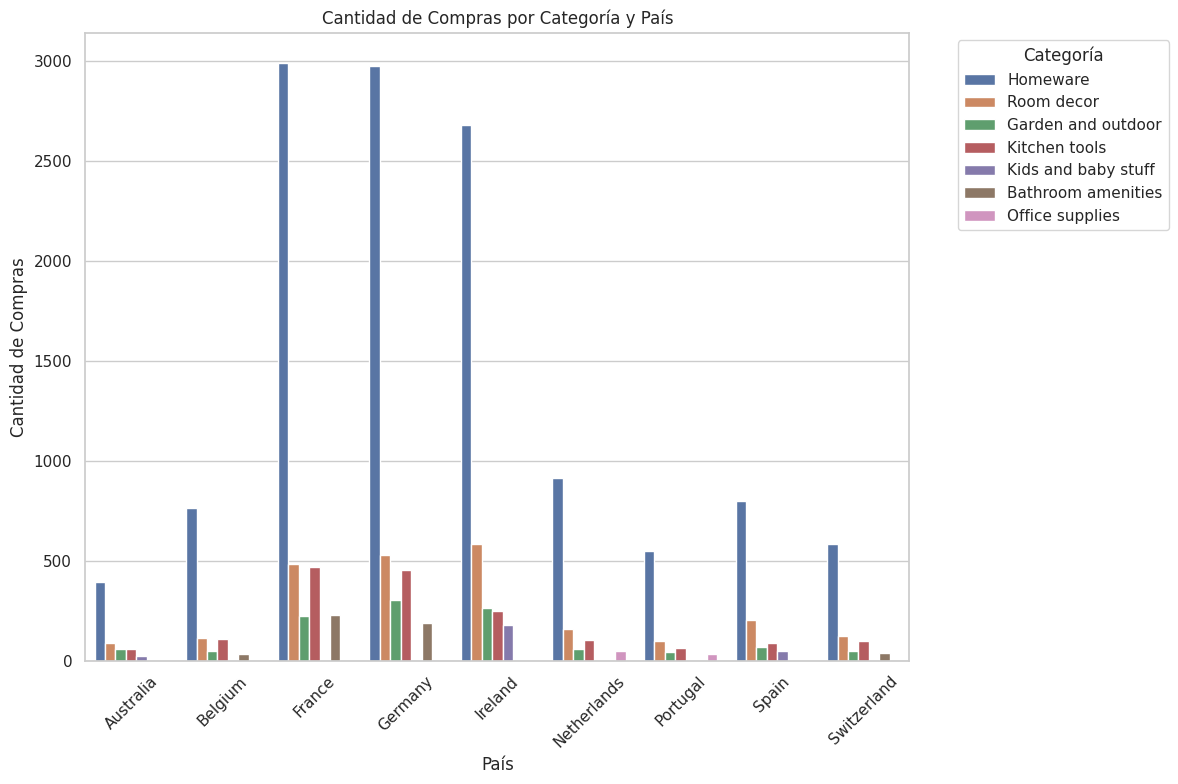

In [ ]:
cat = cat_pais_sorted[cat_pais_sorted['Country'] != 'United Kingdom']
cat.reset_index(drop=True, inplace=True)
cat_mas_vendidas = obtener_categorias_mas_vendidas(cat,5)

plt.figure(figsize=(12, 8))
sns.barplot(data=cat_mas_vendidas, x='Country', y='#', hue='Category')
plt.title('Cantidad de Compras por Categoría y País')
plt.xlabel('País')
plt.ylabel('Cantidad de Compras')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejor visualización
plt.legend(title='Categoría', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Quitamos la categoría 'Homeware' para poder visualizar mejor las siguientes categorías

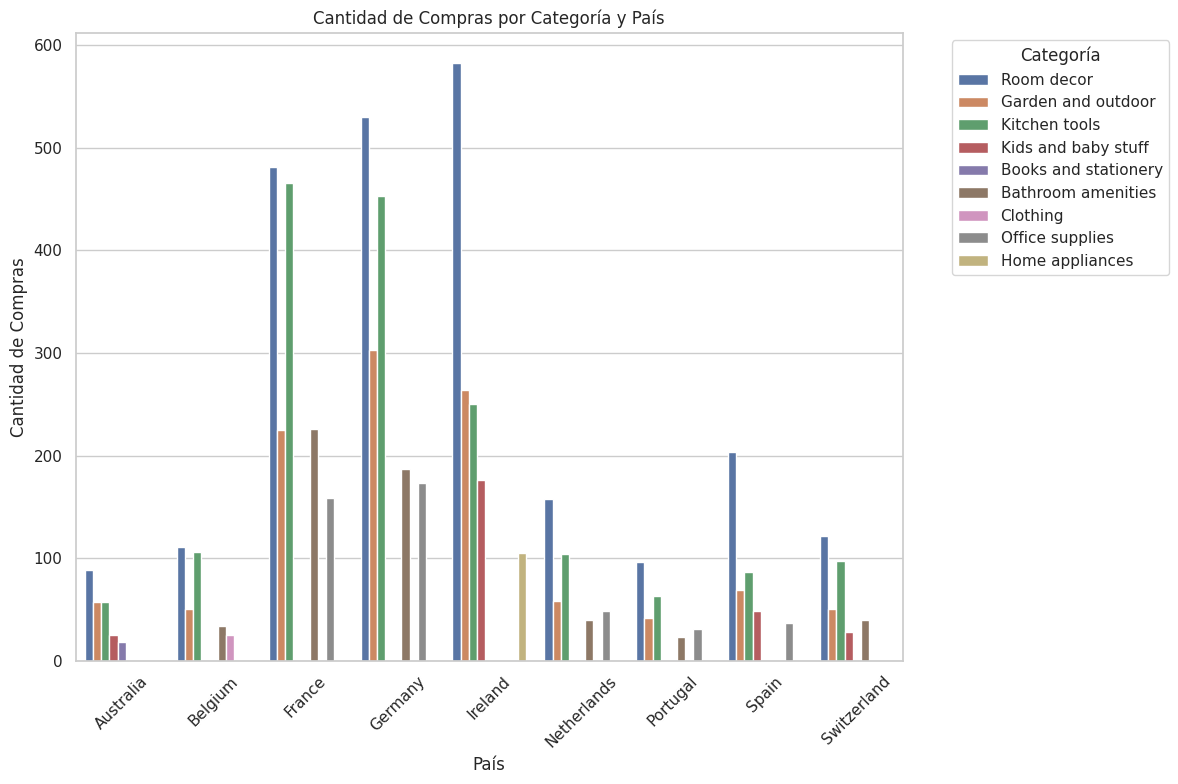

In [ ]:
cat = cat[cat['Category'] != 'Homeware']
cat.reset_index(drop=True, inplace=True)
cat_mas_vendidas = obtener_categorias_mas_vendidas(cat,5)


plt.figure(figsize=(12, 8))
sns.barplot(data=cat_mas_vendidas, x='Country', y='#', hue='Category')
plt.title('Cantidad de Compras por Categoría y País')
plt.xlabel('País')
plt.ylabel('Cantidad de Compras')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejor visualización
plt.legend(title='Categoría', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# **Análisis por clientes**

Cantidad de clientes por cada país

In [ ]:
# Cantidad de clientes x país
df_agrupado = df[['Country','CustomerID']].groupby(['Country']).nunique().sort_values('CustomerID', ascending=False)
df_agrupado = df_agrupado.rename(columns={'CustomerID': 'Cantidad de clientes'})
clientes = df_agrupado['Cantidad de clientes'].sum()
print(f'Cantidad de clientes total: {clientes}')

df_agrupado.head()

Cantidad de clientes total: 4256


,Cantidad de clientes
Country,
United Kingdom,3842
Germany,93
France,86
Spain,29
Belgium,25


### **Clientes con mayor consumo y frecuencia de compra**

In [ ]:
# Clientes con mayores gastos
cliente_gasto = df.groupby(['CustomerID', 'Country'])['LineTotal'].agg('sum').sort_values(ascending=False)
cliente_gasto = cliente_gasto.to_frame(name='Total Gastado')

df_compras = df.groupby('CustomerID')['InvoiceNo'].nunique()
df_primera_compra = df.groupby('CustomerID')['InvoiceFecha'].min()
df_ultima_compra = df.groupby('CustomerID')['InvoiceFecha'].max()

cliente_gasto = cliente_gasto.join(df_compras, on='CustomerID', how='left')
cliente_gasto = cliente_gasto.join(df_primera_compra, on='CustomerID', how='left')
cliente_gasto.columns = ['Total Gastado', 'Cantidad Compras', 'Fecha Primera Compra']
cliente_gasto = cliente_gasto.join(df_ultima_compra, on='CustomerID', how='left')

# Renombrar las columnas
cliente_gasto.columns = ['Total Gastado', 'Cantidad Compras', 'Fecha Primera Compra', 'Fecha Última Compra']
cliente_gasto.head(10)

,,Total Gastado,Cantidad Compras,Fecha Primera Compra,Fecha Última Compra
CustomerID,Country,,,,
14646.0,Netherlands,197362.63,66,2010-12-20,2011-12-08
17450.0,United Kingdom,147203.33,40,2010-12-07,2011-12-01
18102.0,United Kingdom,114211.60,52,2010-12-07,2011-12-08
14911.0,Ireland,82633.58,193,2010-12-01,2011-12-08
12415.0,Australia,82571.92,19,2011-01-06,2011-11-15
14156.0,Ireland,72395.51,48,2011-01-14,2011-11-30
17511.0,United Kingdom,70024.70,30,2010-12-01,2011-12-07
16029.0,United Kingdom,62149.70,58,2010-12-01,2011-11-01
16684.0,United Kingdom,53889.76,27,2010-12-16,2011-12-05


### ¿Qué compran los clientes con mayor consumo?

In [ ]:
cliente_gasto = pd.DataFrame(cliente_gasto, columns=['Total Gastado'])
cliente_gasto = cliente_gasto.reset_index()
lista_clientes = cliente_gasto['CustomerID'][0:10]
#Filtramos el dataset para quedarnos solamente con las compras de esos 10 clientes
df_filtrado = df[df['CustomerID'].isin(lista_clientes)]

#Agrupamos por CustomerID y por Description
#Obtenemos la cantidad de veces que cada cliente compró cada artículo
art_Customer = df_filtrado.groupby(['CustomerID', 'Description']).size().to_frame(name='Compras Totales')
art_Customer = art_Customer.sort_values(by='Compras Totales', ascending=False).reset_index()

Compras Totales = Cantidad de veces en el período que compró dicho artículo

In [ ]:
art_customer_14646 = art_Customer[art_Customer['CustomerID'] == 14646]
art_customer_14646.head()

,CustomerID,Description,Compras Totales
7,14646.0,SPACEBOY LUNCH BOX,25
9,14646.0,ROUND SNACK BOXES SET OF4 WOODLAND,24
20,14646.0,DOLLY GIRL LUNCH BOX,19
28,14646.0,ROUND SNACK BOXES SET OF 4 FRUITS,17
32,14646.0,SPACEBOY BIRTHDAY CARD,16


### **Análisis de Invoices**

Cuales son las facturas que más artículos compraron

In [ ]:
# Top de Invoice por cantidad de artículos vendidos
invoice_top_10_cantidad = df.groupby(['InvoiceNo'])['Quantity'].sum().sort_values(ascending=False)
invoice_top_10_cantidad= invoice_top_10_cantidad.to_frame(name='Quantity')
invoice_top_10_productos = df.groupby(['InvoiceNo'])['LineTotal'].sum().sort_values(ascending=False)
invoice_top_10 = invoice_top_10_cantidad.join(invoice_top_10_productos, on='InvoiceNo')
df_country = df.groupby(['InvoiceNo'])['Country'].first().to_frame(name='Country')
invoice_top_10 = invoice_top_10.join(df_country, on='InvoiceNo')
df_fecha = df.groupby(['InvoiceNo'])['InvoiceFecha'].first().to_frame(name='InvoiceFecha')
invoice_top_10 = invoice_top_10.join(df_fecha, on='InvoiceNo')
invoice_top_10.head(10)

,Quantity,LineTotal,Country,InvoiceFecha
InvoiceNo,,,,
574941,12316,48164.75,United Kingdom,2011-11-07
576365,11204,44402.47,United Kingdom,2011-11-14
562439,9826,15886.54,United Kingdom,2011-08-04
552883,9768,11399.60,Netherlands,2011-05-12
572035,9512,14210.40,Netherlands,2011-10-20
556917,9258,15856.50,Australia,2011-06-15
548011,9080,12189.20,Netherlands,2011-03-29
563076,9012,13425.60,Netherlands,2011-08-11
550461,7714,18805.90,United Kingdom,2011-04-18


### **Análisis de tiempo**

Se caluclan la cantidad de artículos vendidos por día, debajo se grafica para comparar la cantidad de facturas por día

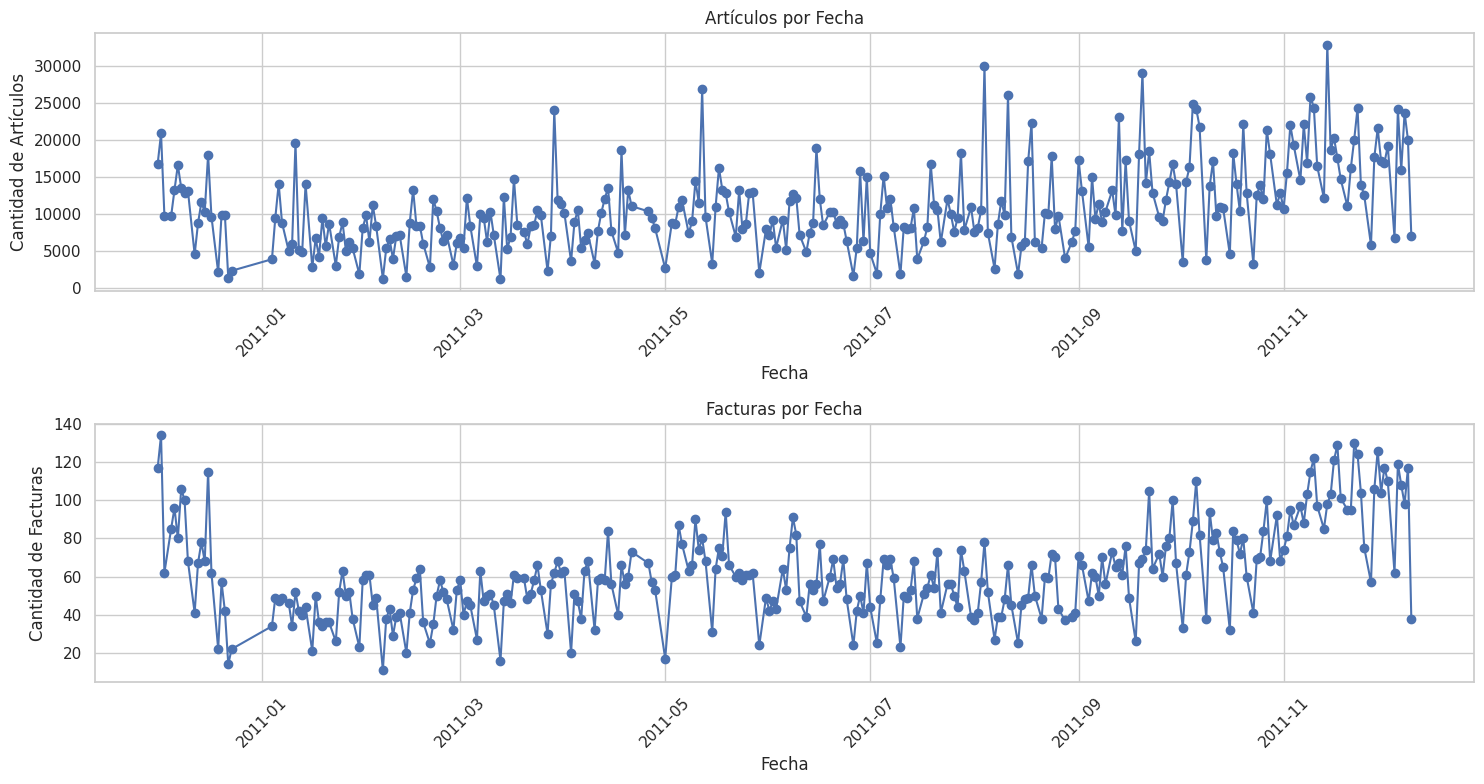

In [ ]:
# Cálculo de las ventas totales por día
ventas_por_fecha = df.groupby('InvoiceFecha')['Quantity'].sum()

#Facturas por día
facturas_por_fecha = df.groupby('InvoiceFecha')['InvoiceNo'].nunique()

# Plot las ventas en el tiempo
plt.figure(figsize=(15, 8))

#Grafico artículos por día
plt.subplot(211)
plt.plot(ventas_por_fecha.index, ventas_por_fecha.values, marker='o', linestyle='-')
plt.title('Artículos por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Artículos')
plt.xticks(rotation=45)
plt.grid(True)

# Gráfico inferior: facturas por fecha
plt.subplot(212)
plt.plot(facturas_por_fecha.index, facturas_por_fecha.values, marker='o', linestyle='-')
plt.title('Facturas por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Facturas')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

Cantidad de ventas por día

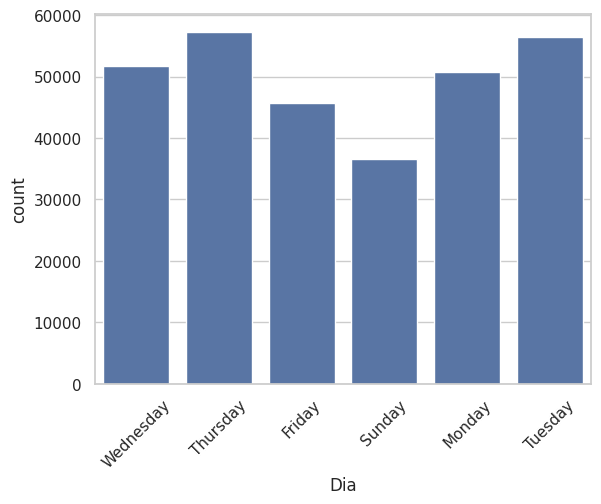

In [ ]:
df['Dia'] = df['InvoiceFecha'].dt.day_name()
sns.countplot(data=df,x='Dia')
plt.xticks(rotation=45)
plt.show()

Cantidad de ventas por mes

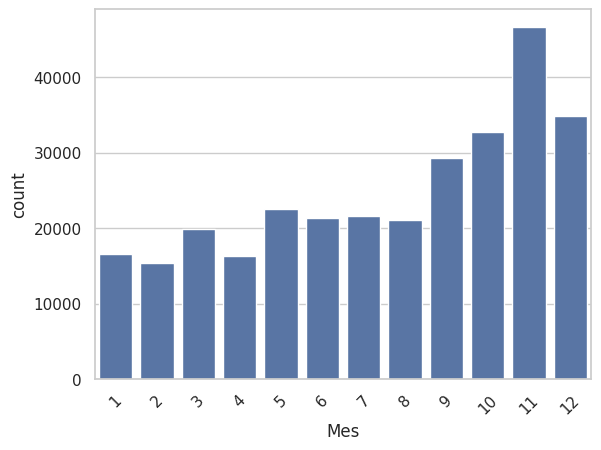

In [ ]:
df['Mes'] = df['InvoiceFecha'].dt.month
sns.countplot(data=df,x='Mes')
plt.xticks(rotation=45)
plt.show()

### **Ahora mostraremos el porcentaje de ventas mensual en función de las ventas totales**

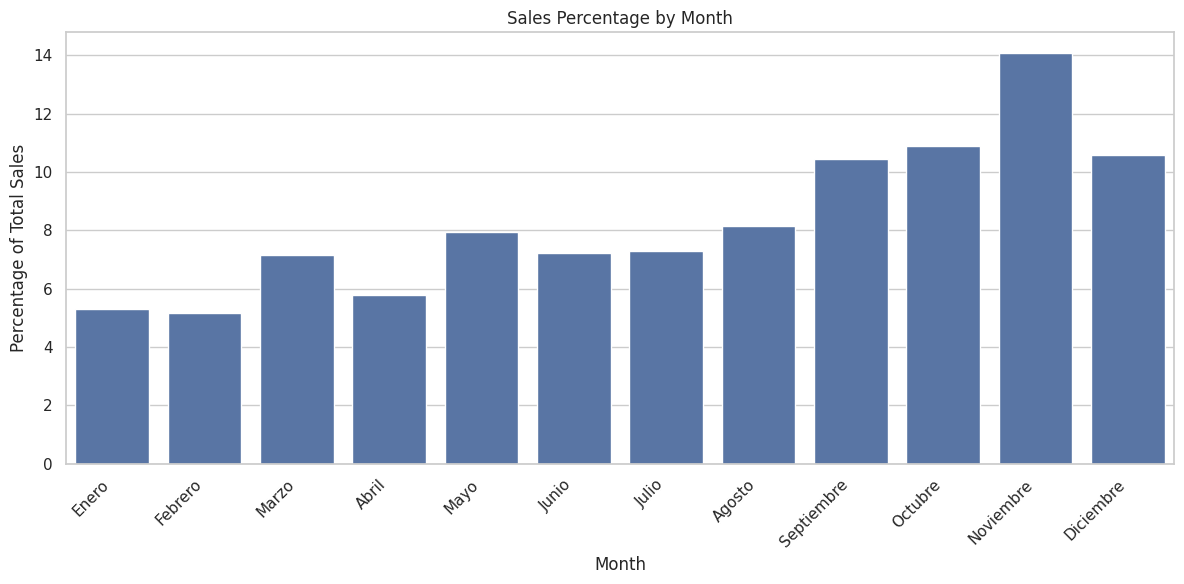

In [ ]:
# Extracción del mes y el año de la columna 'FechaFactura'
df['Mes'] = df['InvoiceFecha'].dt.month

meses = {1: "Enero",2: "Febrero",3: "Marzo",4: "Abril",5: "Mayo",
    6: "Junio",7: "Julio",8: "Agosto",9: "Septiembre",10: "Octubre",
    11: "Noviembre",12: "Diciembre",}

# Agrupación de los datos por mes y año y sume la 'Cantidad' para obtener las ventas totales de cada mes y año.
venta_mensual = df.groupby(['Mes'])['Quantity'].sum()

# Calcular el porcentaje de ventas totales para cada mes y año.
venta_total_meses = venta_mensual.sum()
porcentaje_ventas = (venta_mensual / venta_total_meses) * 100
porcentaje_ventas = porcentaje_ventas.round(2)
porcentaje_ventas.index = porcentaje_ventas.index.map(meses)

# Crea un diagrama de barras usando Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=porcentaje_ventas.index, y=porcentaje_ventas.values, color='b')

# Establecer título y etiquetas de la trama
plt.title('Sales Percentage by Month')
plt.xlabel('Month')
plt.ylabel('Percentage of Total Sales')

# Se gira las etiquetas del eje x para una mejor legibilidad
plt.xticks(rotation=45, ha='right')

# mostrar la trama
plt.tight_layout()
plt.show()

### Por otro lado tenemos como se distribuyen las ventas en las distintas horas del día

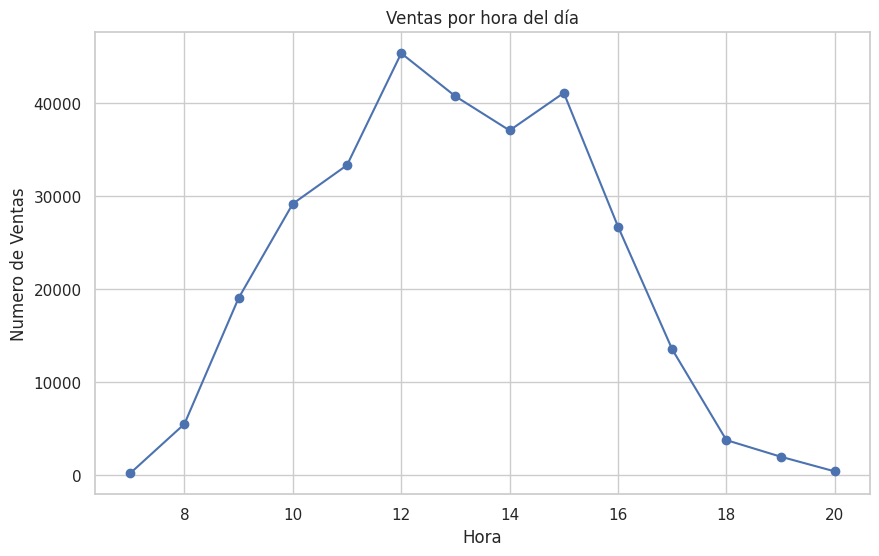

In [ ]:
# Cuente el número de ventas en cada hora.
sales_by_hour = df['Hora'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(sales_by_hour.index, sales_by_hour.values, marker='o', linestyle='-')
plt.title('Ventas por hora del día')
plt.xlabel('Hora')
plt.ylabel('Numero de Ventas')
plt.grid(True)
plt.show()

### **¿Qué producto se compra más por rango horario?**

In [ ]:
df_agrupado = df.groupby(['Hora', 'Description'])['Quantity'].sum()
df_agrupado = df_agrupado.sort_values(ascending=False)
df_agrupado = pd.DataFrame(df_agrupado).reset_index()

def obtener_articulos_x_hora(df):
  # Crear un nuevo DataFrame vacío
  resultado = pd.DataFrame(columns=['Hora', 'Description', 'Quantity'])
  horas = df['Hora'].unique()
  for hora in horas:
      df2 = df[df['Hora'] == hora]
      cantidad_max = df2['Quantity'].max()
      filtrado = df2.loc[df2['Quantity'] == cantidad_max]
      resultado = pd.concat([resultado, filtrado], ignore_index=True)

  return resultado
por_hora = obtener_articulos_x_hora(df_agrupado)
por_hora = por_hora.sort_values(by='Hora').reset_index(drop=True)
por_hora

,Hora,Description,Quantity
0,7,RABBIT NIGHT LIGHT,912
1,8,WHITE HANGING HEART T LIGHT HOLDER,2553
2,9,PACK OF 72 RETROSPOT CAKE CASES,5278
3,10,WORLD WAR 2 GLIDERS ASSTD DESIGNS,8647
4,11,JUMBO BAG RED RETROSPOT,7947
5,12,WORLD WAR 2 GLIDERS ASSTD DESIGNS,13221
6,13,WORLD WAR 2 GLIDERS ASSTD DESIGNS,7056
7,14,JUMBO BAG RED RETROSPOT,4752
8,15,RABBIT NIGHT LIGHT,6350
9,16,JUMBO BAG RED RETROSPOT,3512


## **Análisis RFM**

1. Problema a resolver
2. Procesamiento de datos
3. Selección de atributos
4. Limpieza de outliers
5. Modelo
6. Visualización
7. Exportación de datos

**1. Problema a resolver**
\
El análisis RFM es una técnica basada en datos que ayuda a las empresas a comprender el comportamiento de los clientes e identificar a los clientes más valiosos. RFM significa actualidad, frecuencia y valor monetario, que son las tres métricas utilizadas para segmentar a los clientes. La actualidad mide qué tan recientemente un cliente ha realizado una compra, la frecuencia mide la frecuencia con la que realiza compras y el valor monetario mide cuánto gasta.

Este código transforma los datos limpios en una tabla de métricas RFM para cada cliente, que se puede utilizar para segmentar y analizar el comportamiento del cliente.

La idea sería calcular las métricas de la Actualidad (Recency), frecuencia (Frequency) y valor monetario (Monetary Value).

In [ ]:
df = df_carga.copy()

**2. Procesamiento de datos**

In [ ]:
# Eliminamos la columna 'Unnamed: 0'
df = df.drop('Unnamed: 0', axis = 1)

In [ ]:
# Eliminamos aquellas compras cuyo campo de 'CustomerID' está vacío.
df = df[df['CustomerID'].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 232939 entries, 0 to 298446
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         232939 non-null  int64         
 1   Description       232939 non-null  object        
 2   Quantity          232939 non-null  int64         
 3   UnitPrice         232939 non-null  float64       
 4   CustomerID        232939 non-null  float64       
 5   Country           232939 non-null  object        
 6   LineTotal         232939 non-null  float64       
 7   InvoiceFecha      232939 non-null  datetime64[ns]
 8   InvoiceDiaSemana  232939 non-null  int64         
 9   Hora              232939 non-null  int64         
 10  Category          232939 non-null  object        
 11  ProductId         232939 non-null  int64         
 12  TotalQuantity     232939 non-null  int64         
 13  TotalAmount       232939 non-null  float64       
dtypes: dateti

In [ ]:
df.describe()

,InvoiceNo,Quantity,UnitPrice,CustomerID,LineTotal,InvoiceFecha,InvoiceDiaSemana,Hora,ProductId,TotalQuantity,TotalAmount
count,232939.000000,232939.000000,232939.000000,232939.000000,232939.000000,232939,232939.000000,232939.000000,232939.000000,232939.000000,232939.000000
mean,560578.227691,13.107294,2.788541,15295.798664,24.276159,2011-07-10 10:24:00.284366336,2.607451,12.664049,283.045231,264.153937,490.002807
min,536365.000000,1.000000,0.160000,12347.000000,0.190000,2010-12-01 00:00:00,0.000000,7.000000,1.000000,1.000000,0.390000
25%,549589.000000,2.000000,1.250000,13963.000000,5.040000,2011-04-11 00:00:00,1.000000,11.000000,118.000000,79.000000,155.700000
50%,561774.000000,6.000000,1.950000,15159.000000,14.750000,2011-07-29 00:00:00,2.000000,13.000000,269.000000,144.000000,267.510000
75%,571743.000000,12.000000,3.750000,16782.000000,19.900000,2011-10-19 00:00:00,4.000000,14.000000,455.000000,257.000000,473.150000
max,581587.000000,4800.000000,33.290000,18287.000000,7144.720000,2011-12-09 00:00:00,6.000000,20.000000,611.000000,9826.000000,21181.280000
std,12920.695995,44.840876,2.482541,1705.934254,78.603874,NaN,1.916413,2.276524,184.999379,594.404717,1000.175209


**3. Selección de atributos**

In [ ]:
df_filtered = df [['Quantity', 'UnitPrice', 'LineTotal', 'CustomerID', 'InvoiceNo']]

**4. Limpieza de outliers**

In [ ]:
# Remove outliers from Quantity, Price, and Turnover columns
Q1 = df_filtered.quantile(0.25)
Q3 = df_filtered.quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df_filtered[~((df_filtered < (Q1 - 1.5 * IQR)) | (df_filtered > (Q3 + 1.5 * IQR))).any(axis=1)]


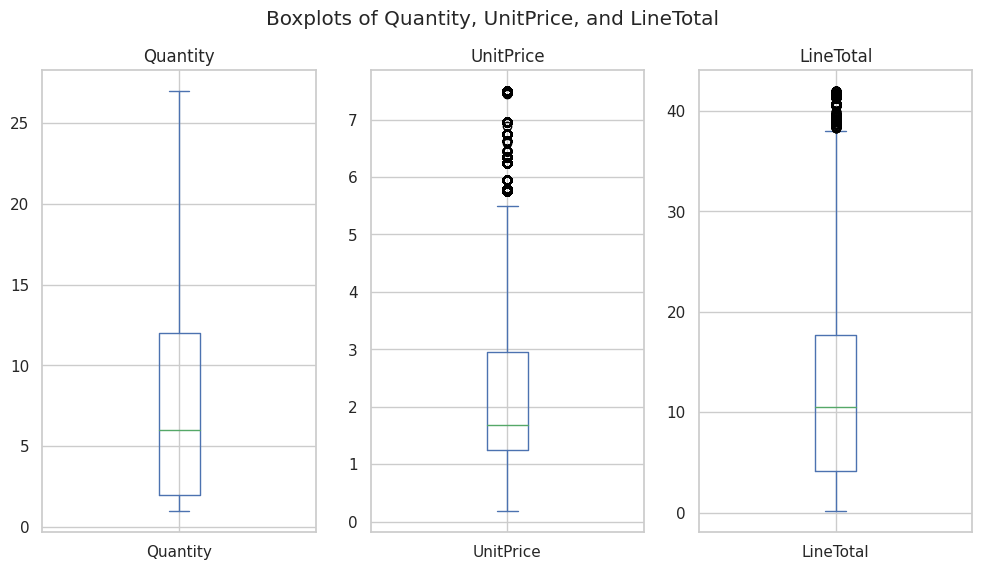

In [ ]:
# Crea una grilla de subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

# Boxplot para la columna 'Quantity'
df_cleaned['Quantity'].plot.box(ax=axs[0], title='Quantity')

# Boxplot para la columna 'UnitPrice'
df_cleaned['UnitPrice'].plot.box(ax=axs[1], title='UnitPrice')

# Boxplot para la columna 'LineTotal'
df_cleaned['LineTotal'].plot.box(ax=axs[2], title='LineTotal')

# Título principal
fig.suptitle('Boxplots of Quantity, UnitPrice, and LineTotal')

# Mostrar gráfica
plt.show()

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193196 entries, 0 to 298446
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Quantity    193196 non-null  int64  
 1   UnitPrice   193196 non-null  float64
 2   LineTotal   193196 non-null  float64
 3   CustomerID  193196 non-null  float64
 4   InvoiceNo   193196 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 8.8 MB


In [ ]:
# Suponiendo que df_cleaned ya ha sido definido y que InvoiceFecha está en un formato adecuado
df_cleaned['InvoiceDate'] = df['InvoiceFecha']
snapshot_date = pd.to_datetime('today')

# Calcula la recencia en días respecto a la fecha más reciente en el dataset
df_cleaned['Date'] = (snapshot_date - df_cleaned['InvoiceDate']).dt.days

<ipython-input-70-dac3148dc964>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-dac3148dc964>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**5. Tabla de Análisis RFM**

In [ ]:
# Agrupación de datos por CustomerID para calcular las métricas RFM
rfm_table = df_cleaned.groupby('CustomerID').agg({
    'Date': 'min', #lambda x: x.min(), # Recency: número mínimo de días desde la última compra
    'LineTotal': 'sum',
    'InvoiceNo': 'nunique'
})

In [ ]:
# Rename columns to Recency, Frequency, and Monetary Value
rfm_table.rename(columns={'Date': 'Recency', 'InvoiceNo': 'Frequency', 'LineTotal': 'Monetary Value'}, inplace=True)

In [ ]:
# Show the RFM table
rfm_table

,Recency,Monetary Value,Frequency
CustomerID,,,
12347.0,4515,1548.76,7
12348.0,4871,52.80,1
12349.0,4531,561.24,1
12350.0,4823,132.60,1
12352.0,4549,739.70,7
...,...,...,...
18280.0,4790,104.45,1
18281.0,4693,46.92,1
18282.0,4520,94.59,2


##Cálculo puntuaciones de cuartil de RFM y creación de puntuación de RFM##

Este código primero calcula las puntuaciones del cuartil para cada una de las métricas de RFM utilizando la función pd.qcut(). El parámetro q especifica el número de cuantiles en los que se dividirán los datos (en este caso, 5) y el parámetro etiquetas asigna una etiqueta a cada cuantil.

La función range() se usa para crear una lista de etiquetas en orden inverso para la métrica de actualidad, mientras que las etiquetas y los parámetros duplicados se usan para crear etiquetas para la métrica de frecuencia que sean compatibles con las etiquetas en orden inverso de actualidad.

In [ ]:
# Calculate quartile scores for each RFM metric
r_quartiles = pd.qcut(rfm_table['Recency'], q=5, labels=range(5, 0, -1))
f_quartiles = pd.qcut(rfm_table['Frequency'], q=5, labels=range(1, 5), duplicates='drop')
m_quartiles = pd.qcut(rfm_table['Monetary Value'], q=5, labels=range(1, 6))

A continuación, el código crea nuevas columnas en el marco de datos rfm_table para las puntuaciones de cuartil utilizando el operador [] para asignar las puntuaciones de cuartil a las columnas R, F y M.

In [ ]:
# Create new columns for the quartile scores
rfm_table['R'] = r_quartiles
rfm_table['F'] = f_quartiles
rfm_table['M'] = m_quartiles

- R: esta columna representa el cuartil de actualidad del cliente. A los clientes con un valor reciente más bajo (es decir, compras más recientes) se les asigna una puntuación de cuartil más alta.

- F: Esta columna representa el cuartil de frecuencia del cliente. A los clientes con un valor de frecuencia más alto (es decir, compras más frecuentes) se les asigna una puntuación de cuartil más alta.

- M: esta columna representa el cuartil del valor monetario del cliente. A los clientes con un valor monetario más alto (es decir, mayor gasto total) se les asigna una puntuación de cuartil más alta.

- RFM: esta columna representa la combinación de los cuartiles de actualidad, frecuencia y valor monetario en una sola puntuación.

In [ ]:
# Concatenate the RFM quartile scores into a single column
rfm_table['RFM'] = rfm_table['R'].astype(str) + rfm_table['F'].astype(str) + rfm_table['M'].astype(str)
rfm_table

,Recency,Monetary Value,Frequency,R,F,M,RFM
CustomerID,,,,,,,
12347.0,4515,1548.76,7,5,4,5,545
12348.0,4871,52.80,1,1,1,1,111
12349.0,4531,561.24,1,4,1,4,414
12350.0,4823,132.60,1,1,1,2,112
12352.0,4549,739.70,7,3,4,4,344
...,...,...,...,...,...,...,...
18280.0,4790,104.45,1,1,1,2,112
18281.0,4693,46.92,1,1,1,1,111
18282.0,4520,94.59,2,5,1,2,512


El código concatena los niveles de cada métrica para crear un segmento RFM y luego asigna cada segmento RFM a un nombre de segmento utilizando un diccionario segment_map predefinido.

In [ ]:
# Define functions to map RFM scores to tiers
def r_score(x):
    if x >= 4:
        return 'High'
    elif x >= 2:
        return 'Medium'
    else:
        return 'Low'

def fm_score(x):
    if x >= 4:
        return 'High'
    elif x >= 2:
        return 'Medium'
    else:
        return 'Low'

# Create new columns for the RFM tiers
rfm_table['R Tier'] = rfm_table['R'].apply(r_score)
rfm_table['F Tier'] = rfm_table['F'].apply(fm_score)
rfm_table['M Tier'] = rfm_table['M'].apply(fm_score)

# Create a new column for the RFM segment
rfm_table['RFM Segment'] = rfm_table['R Tier'] + rfm_table['F Tier'] + rfm_table['M Tier']

# Map the RFM segment to the corresponding segment name
segment_map = {
    'LowLowLow': 'Hibernating',
    'LowLowMedium': 'At Risk',
    'LowLowHigh': 'Can\'t Lose',
    'LowMediumLow': 'About to Sleep',
    'LowMediumMedium': 'Need Attention',
    'LowMediumHigh': 'Loyal Customers',
    'LowHighLow': 'Promising',
    'LowHighMedium': 'New Customers',
    'LowHighHigh': 'Potential Loyalists',
    'MediumLowLow': 'About to Churn',
    'MediumLowMedium': 'At Risk',
    'MediumLowHigh': 'Can\'t Lose',
    'MediumMediumLow': 'Need Attention',
    'MediumMediumMedium': 'Loyal Customers',
    'MediumMediumHigh': 'Loyal Customers',
    'MediumHighLow': 'Promising',
    'MediumHighMedium': 'Promising',
    'MediumHighHigh': 'Potential Loyalists',
    'HighLowLow': 'Champions',
    'HighLowMedium': 'Champions',
    'HighLowHigh': 'Champions',
    'HighMediumLow': 'Champions',
    'HighMediumMedium': 'Champions',
    'HighMediumHigh': 'Champions',
    'HighHighLow': 'Champions',
    'HighHighMedium': 'Champions',
    'HighHighHigh': 'Champions'
}
rfm_table['Segment'] = rfm_table['RFM Segment'].map(segment_map)
rfm_table

,Recency,Monetary Value,Frequency,R,F,M,RFM,R Tier,F Tier,M Tier,RFM Segment,Segment
CustomerID,,,,,,,,,,,,
12347.0,4515,1548.76,7,5,4,5,545,High,High,High,HighHighHigh,Champions
12348.0,4871,52.80,1,1,1,1,111,Low,Low,Low,LowLowLow,Hibernating
12349.0,4531,561.24,1,4,1,4,414,High,Low,High,HighLowHigh,Champions
12350.0,4823,132.60,1,1,1,2,112,Low,Low,Medium,LowLowMedium,At Risk
12352.0,4549,739.70,7,3,4,4,344,Medium,High,High,MediumHighHigh,Potential Loyalists
...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,4790,104.45,1,1,1,2,112,Low,Low,Medium,LowLowMedium,At Risk
18281.0,4693,46.92,1,1,1,1,111,Low,Low,Low,LowLowLow,Hibernating
18282.0,4520,94.59,2,5,1,2,512,High,Low,Medium,HighLowMedium,Champions


El marco de datos rfm_table resultante incluye columnas para los niveles de RFM, segmentos de RFM y nombres de segmentos, lo que proporciona una manera de segmentar a los clientes en función de su comportamiento de compra y asignarlos a diferentes categorías para marketing dirigido u otros fines.

In [ ]:
segment_counts = rfm_table['Segment'].value_counts().reset_index()

In [ ]:
segment_counts.columns = ['Segment', 'Count']
segment_counts

,Segment,Count
0,Champions,1645
1,At Risk,946
2,Loyal Customers,444
3,Hibernating,327
4,About to Churn,323
5,Can't Lose,187
6,Potential Loyalists,128
7,Need Attention,39
8,Promising,15
9,About to Sleep,7


**6. Visualización**

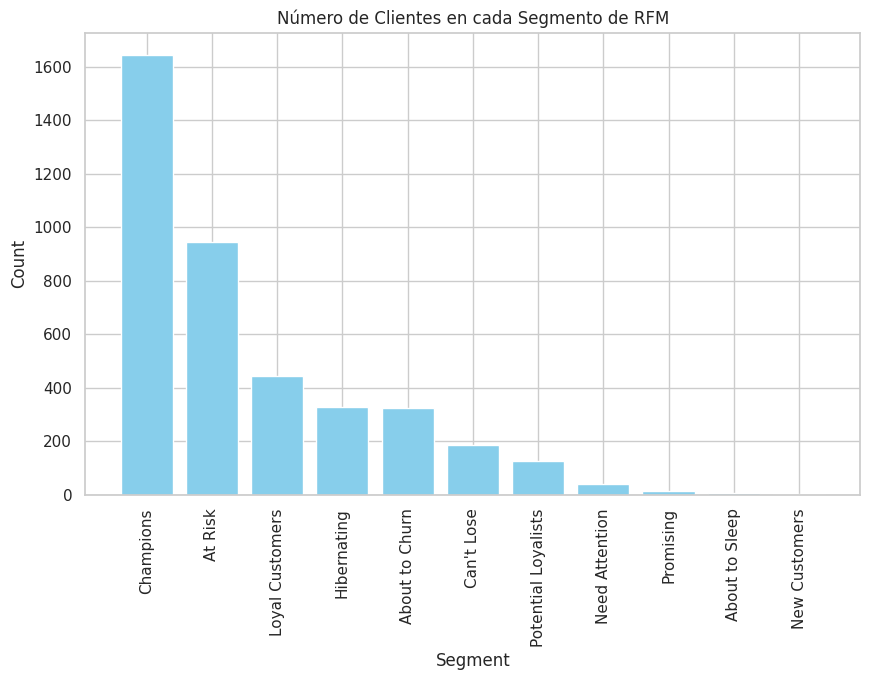

In [ ]:
# Para la gráfica de barras, puedes usar matplotlib
import matplotlib.pyplot as plt

# Ordenar el conteo de segmentos para el gráfico
segment_counts_sorted = segment_counts.sort_values('Count', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(segment_counts_sorted['Segment'], segment_counts_sorted['Count'], color='skyblue')
plt.title('Número de Clientes en cada Segmento de RFM')
plt.xlabel('Segment')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rota las etiquetas del eje x para que sean legibles
plt.show()

A partir de esta información ya se podrían realizar estrategias enfocadas en cada tipo de cliente en particular, como por ejemplo: estrategias de marketing para fidelizar a los clientes o para retenerlos, o incluso, para poder vender más a aquellos clientes que son "Champions", etc.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Captura3.JPG to Captura3.JPG


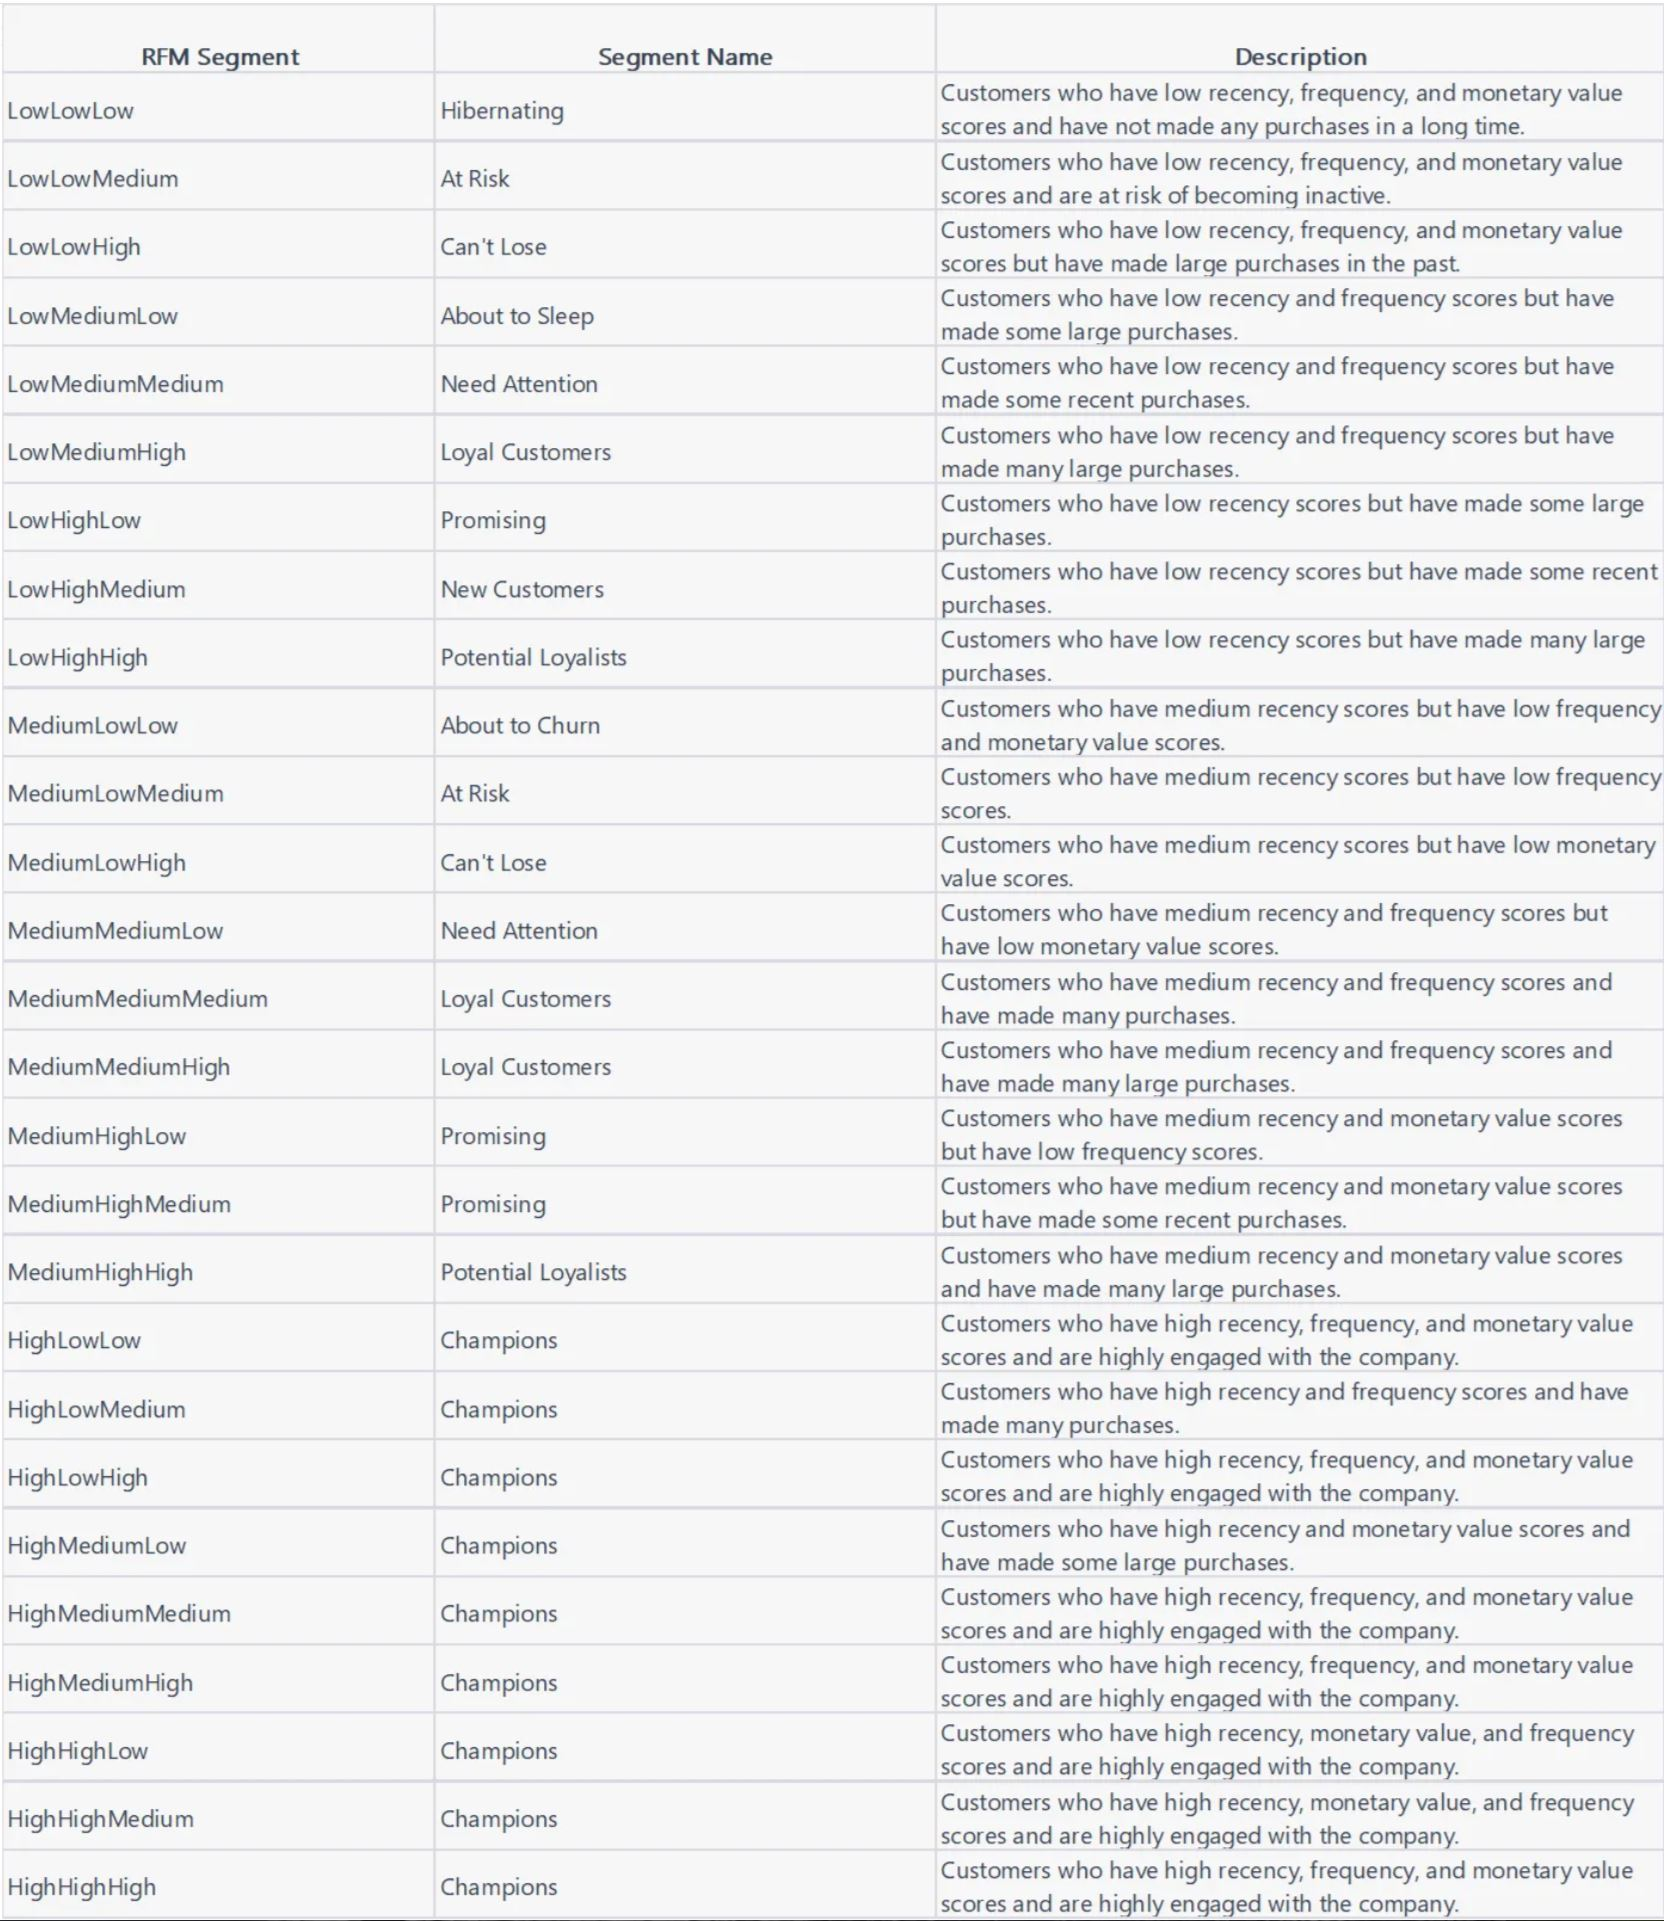

In [ ]:
from IPython.display import Image
Image('Captura3.JPG')  # reemplaza 'nombre_del_archivo.jpg' con el nombre de tu archivo

**7. Exportación de datos**

In [ ]:
rfm_table.to_excel(dirBase + "analisisRFM.xlsx")

# **MODELO 1: Clustering de clientes**



# **1. Problema a resolver**

Clasificar los clientes de acuerdo a sus hábitos de compra, de modo que el departamento de Marketing pueda tomar distintas acciones tendientes a hacer crecer el negocio.

**Planteo.**

Aplicamos la conformación de clusters mediante distintas técnicas para poder conformar segmentos de clientes de acuerdo a datos que expresen sus habitos de compra.

**Importación de datos.**

Se importa el data set con el que se va a trabajar.

In [ ]:
#Se importan las librerías necesarias
import pandas as pd
import datetime as dt
import numpy as np
from collections import Counter

# Montar drive para cargar la base de datos
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Cambiar aquí el directorio donde se encuentran los archivos
#dirBase = "/content/drive/MyDrive/Projecto_Senpai/"

#Carga de los datos
df = pd.read_excel(dirBase + "customer_procesado.xlsx")

### **2. Generación de nuevos atributos.**

*   CustomerQuantity - Cantidad total de productos comprados  por el cliente.
*   CustomerAmount - Cantidad total de dinero gastado por el cliente.
*   CustomerQPurchase - Cantidad total de compras que realizó el cliente.

In [ ]:
df_nuevo = df.groupby('CustomerID').agg(CustomerQuantity=pd.NamedAgg(column='Quantity', aggfunc='sum'), CustomerAmount=pd.NamedAgg(column='LineTotal', aggfunc='sum'), CustomerQPurchase=pd.NamedAgg(column='InvoiceNo', aggfunc=pd.Series.nunique))

In [ ]:
#hacemos esto para que el CustomerID sea un campo de la tabla y no quede como indice
df_nuevo = df_nuevo.reset_index(drop=False)

**Eliminación de outliers.**

Depuramos algunos outliers que generan notorias distorsiones en la conformación de los clusters.

In [ ]:
#depuramos outliers del dataset original
df_nuevo.drop(df_nuevo[df_nuevo['CustomerQPurchase']>= 10].index , inplace = True)

df_nuevo.drop(df_nuevo[df_nuevo['CustomerQuantity']>= 7500].index , inplace = True)

df_nuevo.drop(df_nuevo[df_nuevo['CustomerAmount']>= 40000].index , inplace = True)

# **Modelo**

Aplicaremos tres técnicas de clustering para encontrar la más conveniente:
- KMeans
- DBScan
- Jerarquico

# **Formación de clusters usando KMeans.**

Se aplica la tecnica de KMeans para generar los clusters.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Normalizamos los datos para que no se generen distorsiones al tratar con magnitudes diferentes.


In [ ]:
# Conformamos una matriz para set utilizada por los algoritmos
# También normalizamos

from sklearn import preprocessing

x = df_nuevo.iloc[:,[1,2,3]].values

x_original = x #copio los valores originales para graficarlos luego con el valore real y no el normalizado

normalizer = preprocessing.StandardScaler()
x = normalizer.fit_transform(x)

# **Cantidad de clusters óptima.**

Determinamos el número óptimo de clusters, mediante el método del codo.
El número adecuado segun la siguiente gráfica, serían 3 clusters.

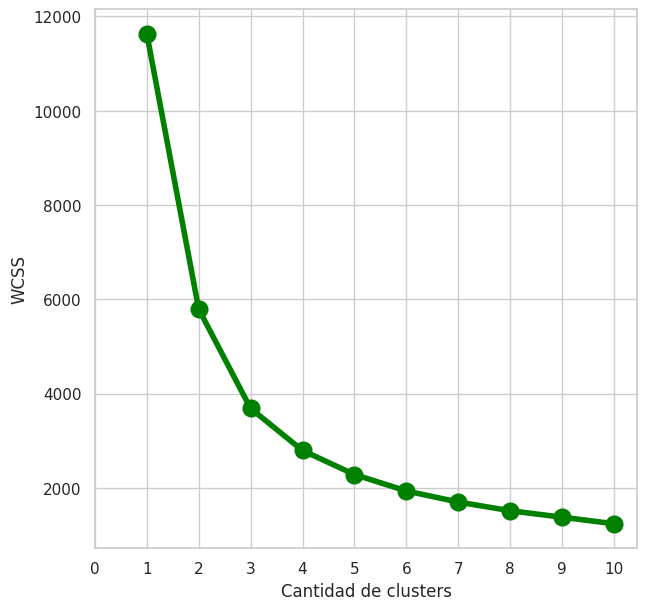

In [ ]:

WCSS = []
for i in range(1,11):
    model = KMeans(n_clusters = i,init = 'k-means++')
    model.fit(x)
    WCSS.append(model.inertia_)
fig = plt.figure(figsize = (7,7))
plt.plot(range(1,11),WCSS, linewidth=4, markersize=12,marker='o',color = 'green')
plt.xticks(np.arange(11))
plt.xlabel("Cantidad de clusters")
plt.ylabel("WCSS")
plt.show()

Se aplica KMeans y se genera el vector con los clusters por cada cliente.

In [ ]:
model = KMeans(n_clusters = 3, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
y_clustersKM = model.fit_predict(x)
y_clusters = y_clustersKM

In [ ]:
from sklearn.metrics import silhouette_score

sskm = silhouette_score(x, model.labels_)

print(f"KMeans Silhouette Score: {sskm:.2f}")


KMeans Silhouette Score: 0.61


Se genera una gráfica para visualizar los distintos clusters generados.

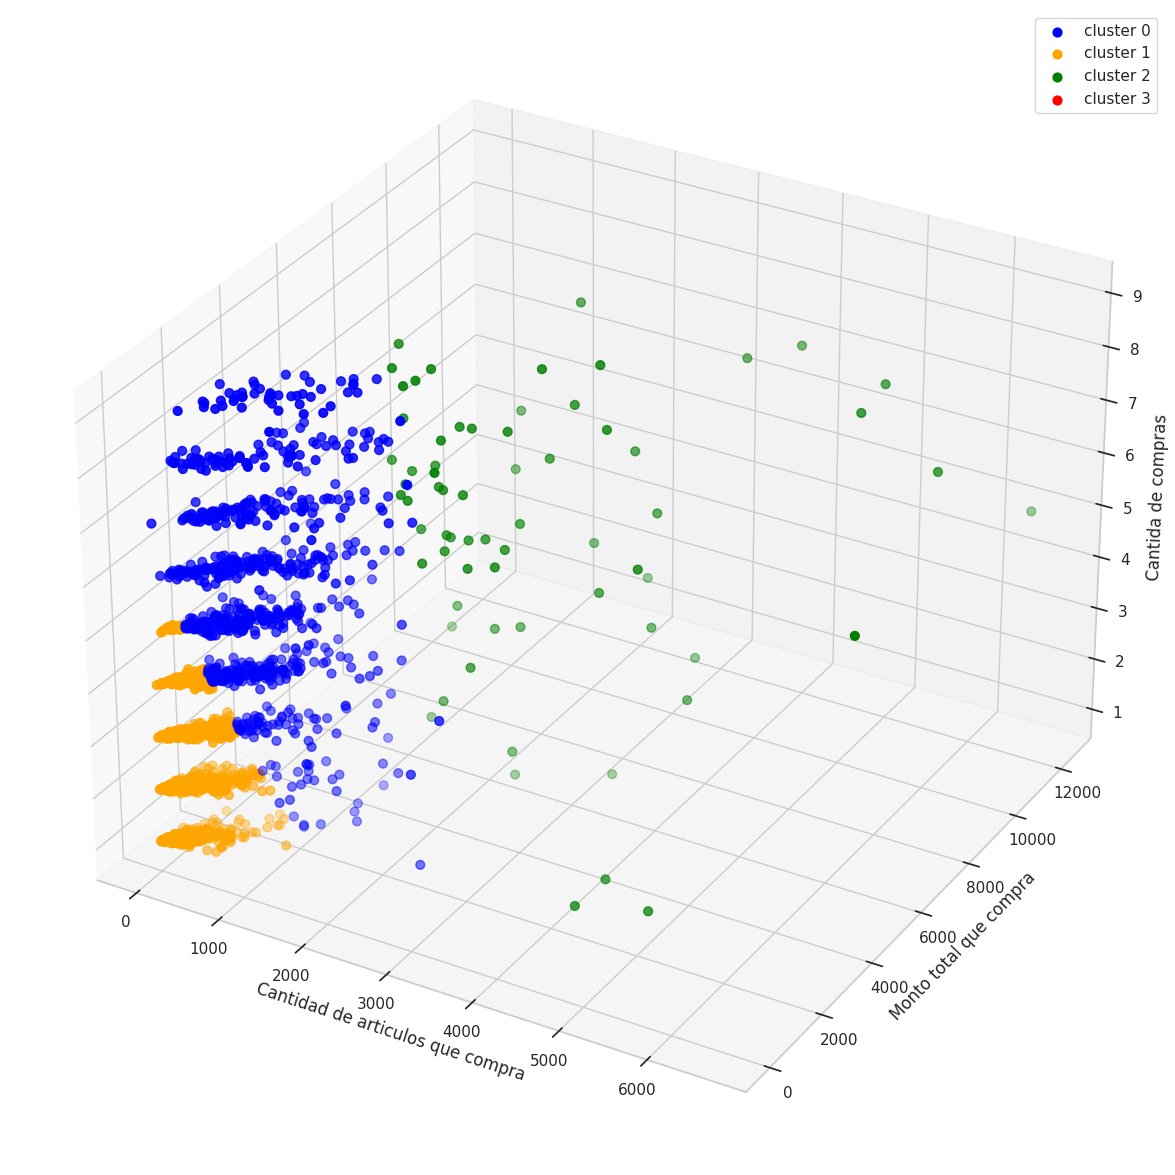

In [ ]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_original[y_clusters == 0,0],x_original[y_clusters == 0,1],x_original[y_clusters == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(x_original[y_clusters == 1,0],x_original[y_clusters == 1,1],x_original[y_clusters == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(x_original[y_clusters == 2,0],x_original[y_clusters == 2,1],x_original[y_clusters == 2,2], s = 40 , color = 'green', label = "cluster 2")
ax.scatter(x_original[y_clusters == 3,0],x_original[y_clusters == 3,1],x_original[y_clusters == 3,2], s = 40 , color = 'red', label = "cluster 3")
#ax.scatter(x[y_clusters == 4,0],x[y_clusters == 4,1],x[y_clusters == 4,2], s = 40 , color = 'purple', label = "cluster 4")
ax.set_xlabel('Cantidad de articulos que compra')
ax.set_ylabel('Monto total que compra')
ax.set_zlabel('Cantida de compras')
ax.legend()
plt.show()

# **Formación de clusters usando DBScan.**

Se aplica la tecnica de DBScan para generar los clusters.

In [ ]:
#aplicamos DBScan
from sklearn.cluster import DBSCAN

Ejecutamos el algoritmo y generamos la clusterización

In [ ]:
clustering = DBSCAN(eps=0.3, min_samples=10).fit(x)
y_clustersDBS = clustering.labels_
y_clusters = clustering.labels_

In [ ]:
# Calculamos la metrica
ssdbscan = silhouette_score(x, clustering.labels_)
# Print
print(f"DBScan Silhouette Score: {ssdbscan:.2f}")
print(f"DBScan clusters: {len(np.unique(y_clustersDBS))}")

DBScan Silhouette Score: 0.29
DBScan clusters: 10


Generamos la gráfica para visualizar la clusterización generada.

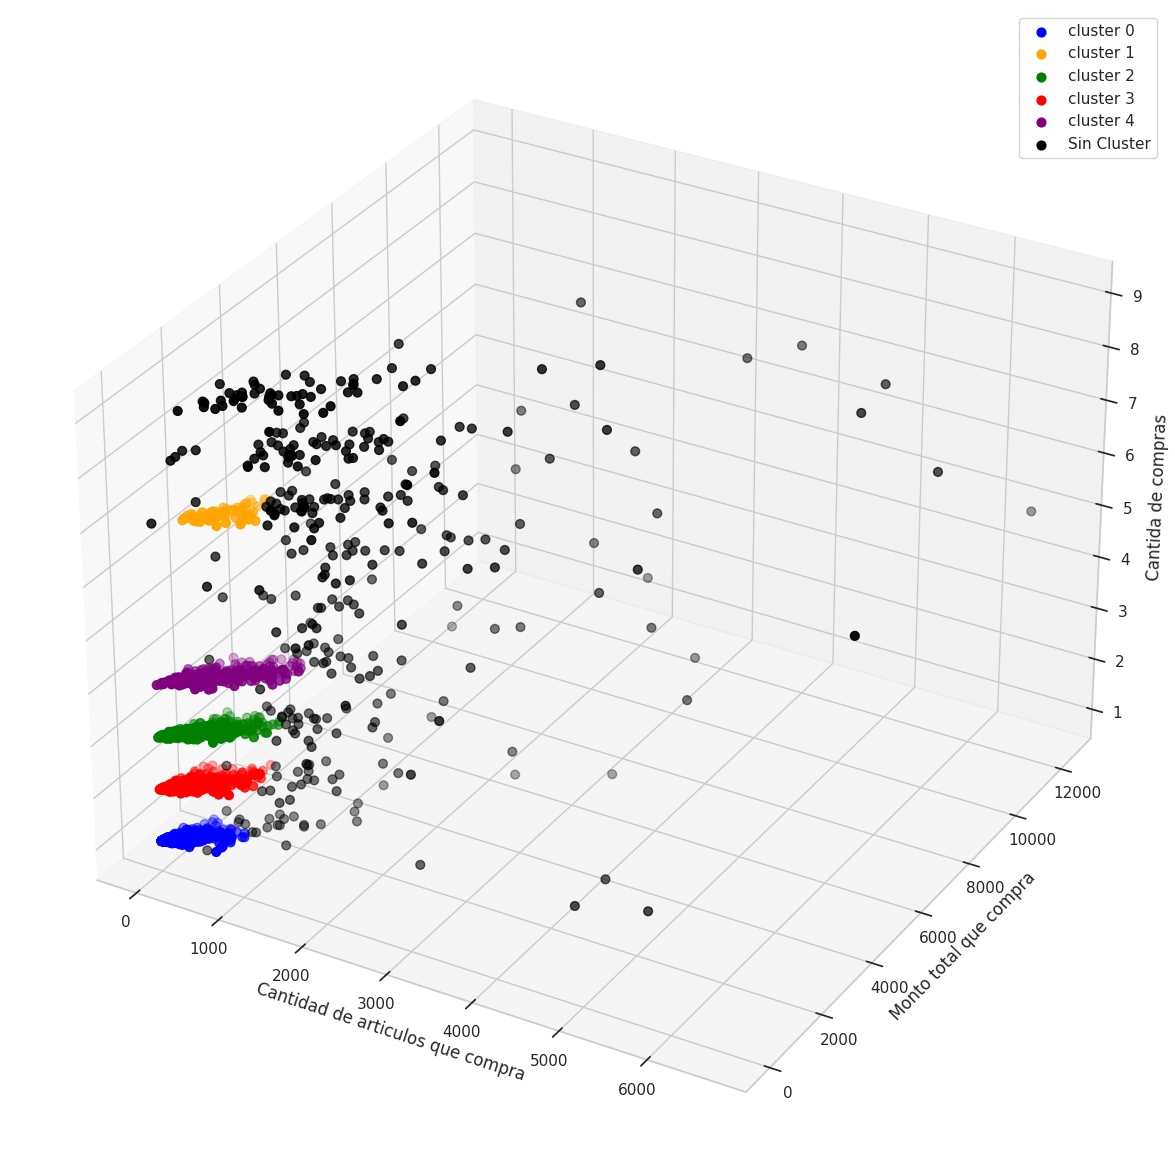

In [ ]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_original[y_clusters == 0,0],x_original[y_clusters == 0,1],x_original[y_clusters == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(x_original[y_clusters == 1,0],x_original[y_clusters == 1,1],x_original[y_clusters == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(x_original[y_clusters == 2,0],x_original[y_clusters == 2,1],x_original[y_clusters == 2,2], s = 40 , color = 'green', label = "cluster 2")
ax.scatter(x_original[y_clusters == 3,0],x_original[y_clusters == 3,1],x_original[y_clusters == 3,2], s = 40 , color = 'red', label = "cluster 3")
ax.scatter(x_original[y_clusters == 4,0],x_original[y_clusters == 4,1],x_original[y_clusters == 4,2], s = 40 , color = 'purple', label = "cluster 4")
ax.scatter(x_original[y_clusters == -1,0],x_original[y_clusters == -1,1],x_original[y_clusters == -1,2], s = 40 , color = 'black', label = "Sin Cluster")
ax.set_xlabel('Cantidad de articulos que compra')
ax.set_ylabel('Monto total que compra')
ax.set_zlabel('Cantida de compras')
ax.legend()
plt.show()

Conclusión.
Luego de varias pruebas, descartamos esta segmentación porque el dato de la cantidad de compras, es un dato practicamente determinante y genera clusters estancos que no consiguen generar un 'criterio' más amplio de segmentación. Por otro lado si probamos otros parámetros para ampliar el criterio de segmentación, se terminan generando pocos clusters que contienen practicamente todos los puntos.


# **Formación de clusters usando cluster jerárquico.**




In [ ]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
plt.rcParams['figure.figsize'] = [8, 8]
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation


Aplicamos el modelo

In [ ]:
y_clustersHC = linkage(x,
            method='ward',
            metric='euclidean')

Se genera el dendograma para visualización.

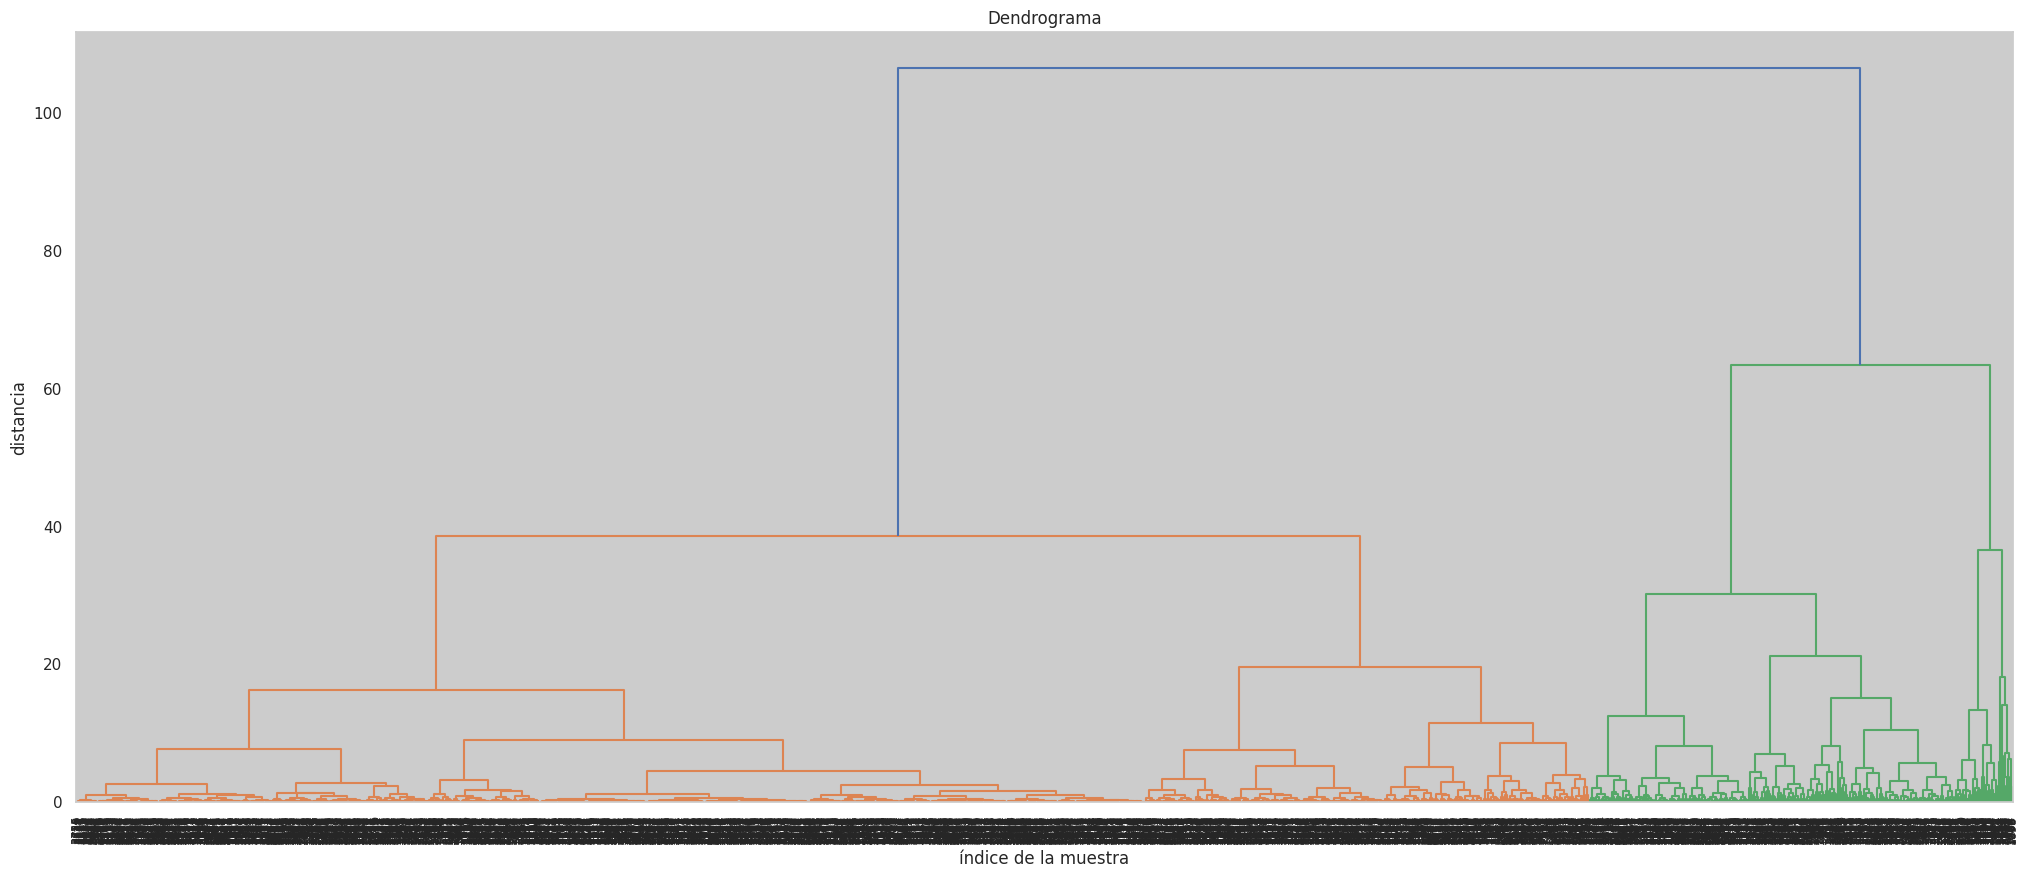

In [ ]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Dendrograma')
plt.xlabel('índice de la muestra')
plt.ylabel('distancia')
dendrogram(
    y_clustersHC,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

Funcion auxiliar para plotear el deondograma resumido.

In [ ]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

Dendograma final donde se indica el punto de corte.

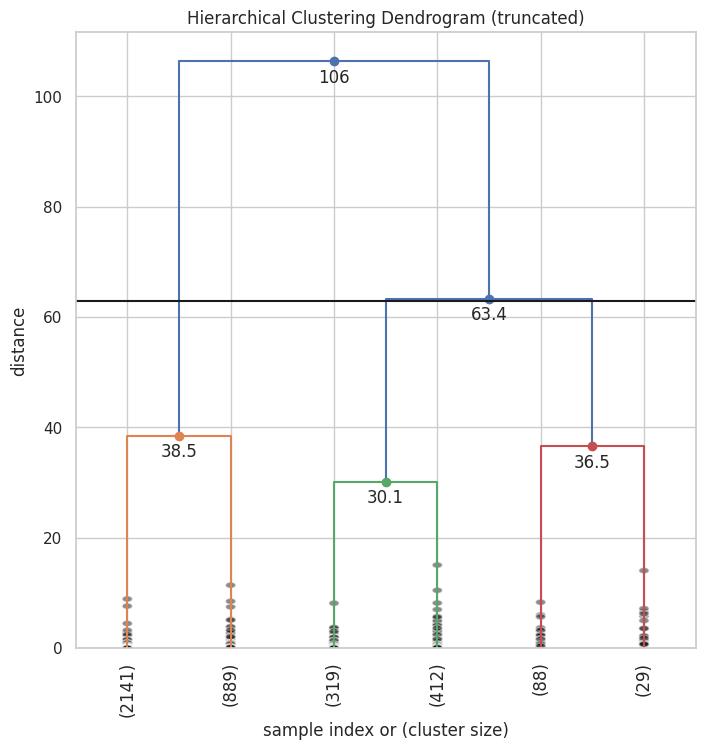

In [ ]:
d_max = 63

fancy_dendrogram(
    y_clustersHC,
    truncate_mode='lastp',
    p=6,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=1,
    max_d=d_max,  # plot a horizontal cut-off line
)
plt.show()

Se aplica el modelo de clusters finales, con 3 clusters.

In [ ]:
from scipy.cluster.hierarchy import fcluster
max_d = 63 # 3 clusters
y_clustersHC = fcluster(y_clustersHC, max_d, criterion='distance')


In [ ]:
ssh = silhouette_score(x , y_clustersHC, metric='euclidean')

print(f"Jerarquico Silhouette Score: {ssh:.2f}")

Jerarquico Silhouette Score: 0.60


Visualización de los clusters.

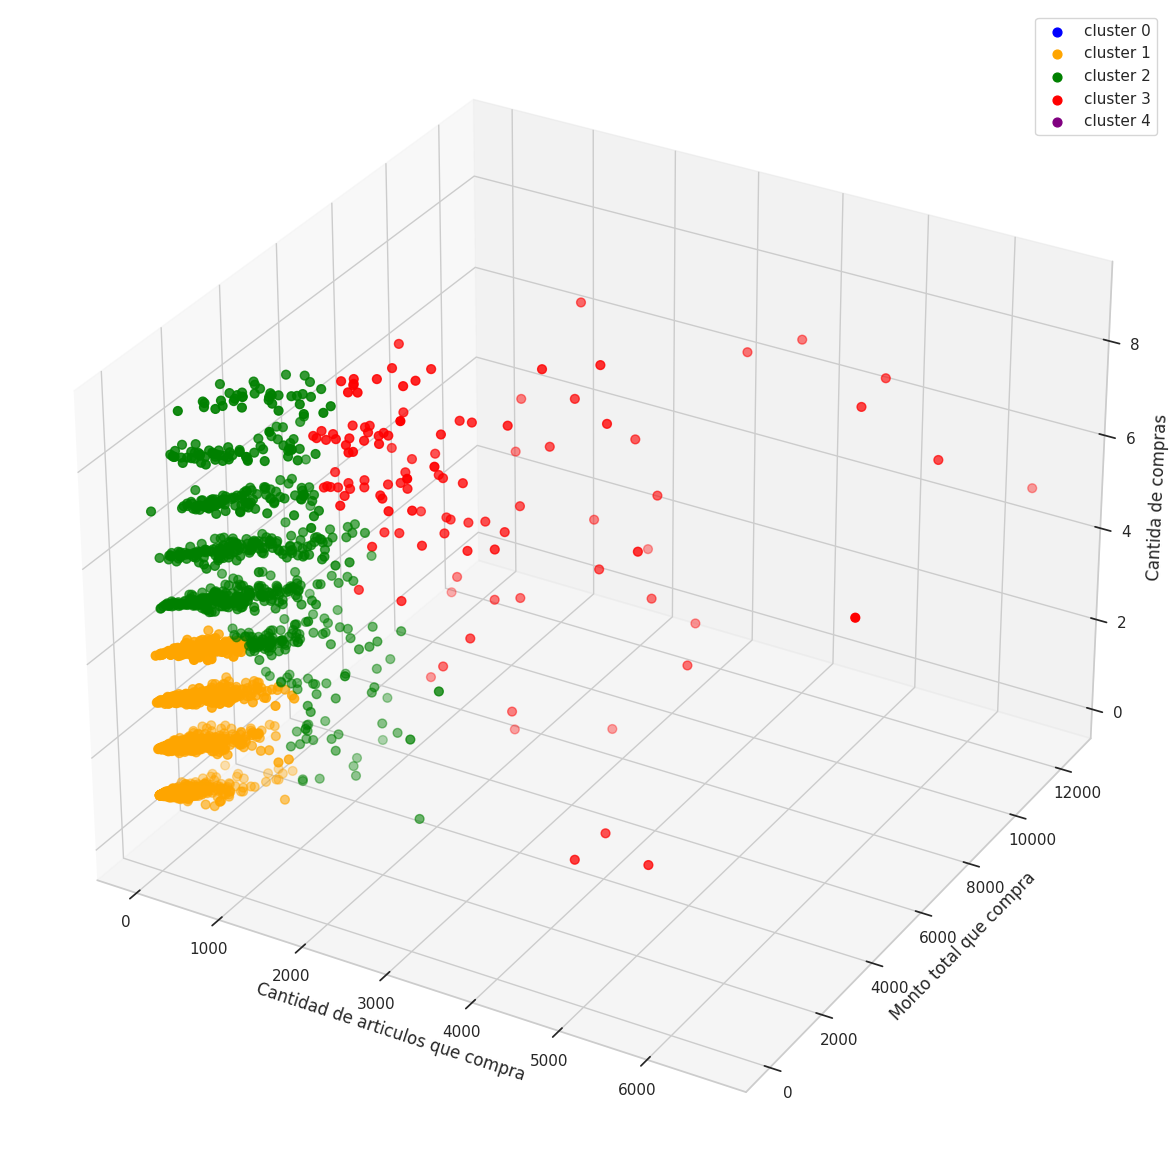

In [ ]:
y_clusters = y_clustersHC

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_original[y_clusters == 0,0],x_original[y_clusters == 0,1],x_original[y_clusters == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(x_original[y_clusters == 1,0],x_original[y_clusters == 1,1],x_original[y_clusters == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(x_original[y_clusters == 2,0],x_original[y_clusters == 2,1],x_original[y_clusters == 2,2], s = 40 , color = 'green', label = "cluster 2")
ax.scatter(x_original[y_clusters == 3,0],x_original[y_clusters == 3,1],x_original[y_clusters == 3,2], s = 40 , color = 'red', label = "cluster 3")
ax.scatter(x_original[y_clusters == 4,0],x_original[y_clusters == 4,1],x_original[y_clusters == 4,2], s = 40 , color = 'purple', label = "cluster 4")
#ax.scatter(x_original[y_clusters == 5,0],x_original[y_clusters == 5,1],x_original[y_clusters == 5,2], s = 40 , color = 'yellow', label = "cluster 5")
#ax.scatter(x_original[y_clusters == 6,0],x_original[y_clusters == 4,1],x_original[y_clusters == 6,2], s = 40 , color = 'black', label = "cluster 6")
ax.set_xlabel('Cantidad de articulos que compra')
ax.set_ylabel('Monto total que compra')
ax.set_zlabel('Cantida de compras')
ax.legend()
plt.show()

# **Visualización de métricas.**

Comparamos las metricas obtenidas por los distintos modelos.

In [ ]:
print(f"KMeans Silhouette Score: {sskm:.2f}")
print(f"DBScan Silhouette Score: {ssdbscan:.2f}")
print(f"Jerarquico Silhouette Score: {ssh:.2f}")

KMeans Silhouette Score: 0.61
DBScan Silhouette Score: 0.29
Jerarquico Silhouette Score: 0.60


**Concluimos que el modelo generado por KMeans es el que tiene mejor Silhouette Score: 0.61 por lo que nos quedamos con ese.**




# **Exportación del modelo**

Exportamos el modelo generado por KMeans.


In [ ]:
joblib.dump(model, dirBase + "clusterkmeans.pkl")

['/content/drive/MyDrive/Projecto_Senpai/EntregaFinal_Senpai/clusterkmeans.pkl']

# **MODELO 3: Sistema de Recomendación de productos usando filtrado colaborativo de recomendación con retroalimentación implícita**#

Modelos de recomendación Explícitos: modelo basado en una puntuación, como una calificación o un me gusta.

Luego cuando hablamos de un modelo implícito nos refererimos a un modelo cuyas puntuaciones de usuarios no son tan obvias en términos de preferencia, como por ejemplo podría ser ser un clic, ver o comprar.

Para la presentación de este modelo de recomendación  hemos seguido los siguientes pasos:

1. Problema a resolver
2. Limpieza y selección de atributos
3. Generación de matriz cliente-producto
4. Partición de datos
5. Modelo
6. Visualización de las metricas
7. Exportación del modelo

El siguiente modelo fue desarrollado en base a la siguiente publicación, adaptada al DataSet en cuestión:
https://nbviewer.org/github/jmsteinw/Notebooks/blob/master/RecEngine_NB.ipynb



# **1. Problema a resolver**

La generación de un modelo que nos permita llevar a cabo recomendaciones de compra de productos surge de la importancia de sugerirle al cliente el próximo artículo bien sea que el cliente necesite o que le pueda despertar el interés por adquirir.

Esto podría resolverse de varias maneras, sin embargo, la idea es poder llevar a cabo pruebas con métricas para entender cuáles parámetros son los mejores.

Modelo de recomendación: mínimos cuadrados alternos (ALS) el cual usa el filtrado colaborativo implícito y viene a ser una modelo de factorización matricial de características latentes.

# **2. Limpieza y selección de atributos**

A partir de los atributos existentes se realiza la preparación de selección de aquellos campos necesarios para la matriz cliente-producto (matriz sparse).

In [ ]:
# Se realiza una copia para no tener que cargar directamente desde el archivo Excel cada vez que necesitemos la información del DataFrame customer_procesado
df = df_carga.copy()

In [ ]:
# Visualización de los datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298447 entries, 0 to 298446
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Unnamed: 0        298447 non-null  int64         
 1   InvoiceNo         298447 non-null  int64         
 2   Description       298447 non-null  object        
 3   Quantity          298447 non-null  int64         
 4   UnitPrice         298447 non-null  float64       
 5   CustomerID        232939 non-null  float64       
 6   Country           298447 non-null  object        
 7   LineTotal         298447 non-null  float64       
 8   InvoiceFecha      298447 non-null  datetime64[ns]
 9   InvoiceDiaSemana  298447 non-null  int64         
 10  Hora              298447 non-null  int64         
 11  Category          298447 non-null  object        
 12  ProductId         298447 non-null  int64         
 13  TotalQuantity     298447 non-null  int64         
 14  Tota

In [ ]:
df_implicit = df[['InvoiceNo', 'ProductId', 'Description', 'Quantity']].groupby(['InvoiceNo', 'ProductId', 'Description']).sum().reset_index()
df_implicit.head()

,InvoiceNo,ProductId,Description,Quantity
0,536365,1,WHITE HANGING HEART T LIGHT HOLDER,6
1,536365,2,WHITE METAL LANTERN,6
2,536365,3,CREAM CUPID HEARTS COAT HANGER,8
3,536365,4,KNITTED UNION FLAG HOT WATER BOTTLE,6
4,536365,5,RED WOOLLY HOTTIE WHITE HEART,6


Se eliminan los datos cuyo registro en 'CustomerId' es NaN.

In [ ]:
df_implicit_2 = df[df['CustomerID'].notna()]
df_implicit_2.head()

,Unnamed: 0,InvoiceNo,Description,Quantity,UnitPrice,CustomerID,Country,LineTotal,InvoiceFecha,InvoiceDiaSemana,Hora,Category,ProductId,TotalQuantity,TotalAmount,Dias,PromSem,Prom21
0,44,536370,MINI PAINT SET VINTAGE,36,0.65,12583.0,France,23.40,2010-12-01,2,8,Homeware,30,302,670.10,0,0.0,0.0
1,46,536371,PAPER CHAIN KIT 50'S CHRISTMAS,80,2.55,13748.0,United Kingdom,204.00,2010-12-01,2,9,Homeware,31,80,204.00,0,0.0,0.0
2,48,536372,HAND WARMER UNION JACK,6,1.85,17850.0,United Kingdom,11.10,2010-12-01,2,9,Homeware,7,6,11.10,0,0.0,0.0
3,49,536373,WHITE HANGING HEART T LIGHT HOLDER,6,2.55,17850.0,United Kingdom,15.30,2010-12-01,2,9,Homeware,1,64,215.28,0,0.0,0.0
4,50,536373,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,20.34,2010-12-01,2,9,Homeware,2,64,215.28,0,0.0,0.0


Se agrupa por CustomerID y por ProductId y se sumas todas las cantidades de productos comprados por el mismo cliente y se resetea al index para que el dataframe no tenga conflicto con las filas agrupadas.

In [ ]:
grouped_df = df_implicit_2[['CustomerID', 'ProductId', 'Description', 'Quantity']].groupby(['CustomerID', 'ProductId', 'Description']).sum().reset_index()
grouped_df.head()

,CustomerID,ProductId,Description,Quantity
0,12347.0,18,ALARM CLOCK BAKELIKE PINK,16
1,12347.0,19,ALARM CLOCK BAKELIKE RED,36
2,12347.0,20,ALARM CLOCK BAKELIKE GREEN,16
3,12347.0,21,VINTAGE HEADS AND TAILS CARD GAME,48
4,12347.0,22,SET 2 RED RETROSPOT TEA TOWELS,6


Se obtiene únicamente el par único de producto-descripción.

In [ ]:
item_lookup = df_implicit_2[['ProductId', 'Description', 'Category']].drop_duplicates()

In [ ]:
item_lookup.head()

,ProductId,Description,Category
0,30,MINI PAINT SET VINTAGE,Homeware
1,31,PAPER CHAIN KIT 50'S CHRISTMAS,Homeware
2,7,HAND WARMER UNION JACK,Homeware
3,1,WHITE HANGING HEART T LIGHT HOLDER,Homeware
4,2,WHITE METAL LANTERN,Homeware


# **3. Generación de matriz cliente-producto**

Elegimos estos campos para la generación de la matriz sparse la cual es la necesaria para poder aplicar el modelo ALS.

Estos campos serían los siguientes:

- CustomerID
- ProductId
- Quantity

In [ ]:
df_implicit_2['CustomerID'] = df_implicit_2.CustomerID.astype(int) # Convert to int for customer ID
cleaned_retail = df_implicit_2[['ProductId', 'Quantity', 'CustomerID']] # Get rid of unnecessary info
grouped_cleaned = cleaned_retail.groupby(['CustomerID', 'ProductId']).sum().reset_index() # Group together
grouped_cleaned.Quantity.loc[grouped_cleaned.Quantity == 0] = 1 # Replace a sum of zero purchases with a one to
# indicate purchased
grouped_purchased = grouped_cleaned.query('Quantity > 0') # Only get customers where purchase totals were positive

In [ ]:
# Visualizamos la matriz resultante
grouped_purchased.head()

,CustomerID,ProductId,Quantity
0,12347,18,16
1,12347,19,36
2,12347,20,16
3,12347,21,48
4,12347,22,6


**Se forman 3 diferentes listas:**

a. Clientes únicos

b. Productos únicos comprados

c. Todas nuestras compras

In [ ]:
customers = list(np.sort(grouped_purchased.CustomerID.unique()))
products = list(grouped_purchased.ProductId.unique())
quantity = list(grouped_purchased.Quantity)

rows = grouped_purchased.CustomerID.astype('category').cat.codes
# Get the associated row indices
cols = grouped_purchased.ProductId.astype('category').cat.codes
# Get the associated column indices
purchases_sparse = sparse.csr_matrix((quantity, (rows, cols)), shape=(len(customers), len(products)))

Para obtener 1 única matriz con todas las transacciones de las compras por producto, cliente y cantidad.

In [ ]:
purchases_sparse

<4248x611 sparse matrix of type '<class 'numpy.int64'>'
	with 141013 stored elements in Compressed Sparse Row format>

Tenemos 4248 clientes con 611  artículos. Para estas interacciones usuario/artículo, 141013 de estos artículos tuvieron una compra.

Para poder saber si es conveniente o no llevar a cabo el modelo ADL se mide que tan esparcidos tenemos los datos de la matriz Customer-ProductId con valores de 'Quantity'.

**Matriz: "purchases_sparse"**

In [ ]:
matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(purchases_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

94.56707845186028

El 94,6% de la matriz de interacción es escasa. Para que el filtrado colaborativo funcione, la escasez máxima con la que podría salirse con la suya probablemente sería de aproximadamente el 99,5%. Estamos muy por debajo de esto, por lo que deberíamos poder obtener resultados decentes.

# **4. Partición de datos**


Se crea función para la partición de datos.

In [ ]:
def make_train(ratings, pct_test = 0.2):
    '''
    Esta función tomará la matriz original de elementos de usuario y "enmascarará" un porcentaje de las calificaciones originales donde
    La interacción usuario-elemento se ha llevado a cabo para su uso como conjunto de prueba. El conjunto de prueba contendrá todas las calificaciones originales,
    mientras que el conjunto de entrenamiento reemplaza el porcentaje especificado de ellos con un cero en la matriz de calificaciones original.

     parámetros:

     ratings: la matriz de ratings original a partir de la cual desea generar un conjunto de entrenamiento/prueba. La prueba es solo una completa.
     copia del conjunto original. Esto tiene la forma de un csr_matrix disperso.

     pct_test: el porcentaje de interacciones usuario-elemento donde tuvo lugar una interacción que desea enmascarar en el
     conjunto de entrenamiento para su posterior comparación con el conjunto de prueba, que contiene todas las calificaciones originales.

     devoluciones:
     Training_set: la versión alterada de los datos originales con un cierto porcentaje de los pares usuario-elemento.
     que originalmente tenía la interacción puesta a cero.

     test_set: una copia de la matriz de calificaciones original, sin modificaciones, para que pueda usarse para ver cómo funciona el orden de clasificación.
     se compara con las interacciones reales.

     user_inds: de los índices de elementos de usuario seleccionados aleatoriamente, qué filas de usuario se modificaron en los datos de entrenamiento.
     Esto será necesario más adelante cuando se evalúe el desempeño vía AUC.
    '''
    test_set = ratings.copy() # Make a copy of the original set to be the test set.
    test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix
    training_set = ratings.copy() # Make a copy of the original data we can alter as our training set.
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of user,item index into list
    random.seed(0) # Set the random seed to zero for reproducibility
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of user-item pairs without replacement
    user_inds = [index[0] for index in samples] # Get the user row indices
    item_inds = [index[1] for index in samples] # Get the item column indices
    training_set[user_inds, item_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space

    return training_set, test_set, list(set(user_inds)) # Output the unique list of user rows that were altered

Esto devolverá nuestro conjunto de entrenamiento, un conjunto de prueba que se ha binarizado a 0/1 para comprado/no comprado y una lista de qué usuarios tenían al menos un elemento enmascarado. Probaremos el rendimiento del sistema de recomendación únicamente en estos usuarios. Estoy enmascarando el 20% de las interacciones usuario/elemento para este ejemplo.

In [ ]:
product_train, product_test, product_users_altered = make_train(purchases_sparse, pct_test = 0.2)

# **5. Modelo de Mínimos Cuadrados Alternos ALS**


Ahora que tenemos nuestra división entrenamiento/prueba, es hora de implementar el algoritmo ALS.

In [ ]:
def implicit_weighted_ALS(training_set, lambda_val = 0.1, alpha = 40, iterations = 10, rank_size = 20, seed = 0):
    '''
     ALS ponderada implícita tomada de Hu, Koren y Volinsky 2008. Diseñado para alternar mínimos cuadrados e implícitos.
     Filtrado colaborativo basado en comentarios.

     parámetros:

     Training_set: nuestra matriz de calificaciones con forma m x n, donde m es el número de usuarios y n es el número de elementos.
     Debería ser una matriz csr escasa para ahorrar espacio.

     lambda_val: se utiliza para la regularización durante la alternancia de mínimos cuadrados. Aumentar este valor puede aumentar el sesgo
     pero disminuye la varianza. El valor predeterminado es 0,1.

     alfa: el parámetro asociado con la matriz de confianza analizada en el artículo, donde Cui = 1 + alfa*Rui.
     El documento encontró un valor predeterminado de 40 más efectivos. Disminuir esto disminuirá la variabilidad en la confianza entre
     varias calificaciones.

     iteraciones: el número de veces que se alterna entre el vector de características del usuario y el vector de características del elemento en
     mínimos cuadrados alternos. Más iteraciones permitirán una mejor convergencia a costa de una mayor computación.
     Los autores encontraron que 10 iteraciones eran suficientes, pero es posible que se requieran más para converger.

     rango_tamaño: el número de características latentes en los vectores de características de usuario/elemento. El documento recomienda variar esto
     entre 20-200. Aumentar el número de funciones puede sobreajustarse, pero podría reducir el sesgo.

     semilla: establece la semilla para obtener resultados reproducibles

     devoluciones:

     Los vectores de características para usuarios y elementos. El producto escalar de estos vectores de características debería darte el resultado esperado.
     "calificación" en cada punto de su matriz original.
     '''

    # first set up our confidence matrix

    conf = (alpha*training_set) # To allow the matrix to stay sparse, I will add one later when each row is taken
                                # and converted to dense.
    num_user = conf.shape[0]
    num_item = conf.shape[1] # Get the size of our original ratings matrix, m x n

    # initialize our X/Y feature vectors randomly with a set seed
    rstate = np.random.RandomState(seed)

    X = sparse.csr_matrix(rstate.normal(size = (num_user, rank_size))) # Random numbers in a m x rank shape
    Y = sparse.csr_matrix(rstate.normal(size = (num_item, rank_size))) # Normally this would be rank x n but we can
                                                                 # transpose at the end. Makes calculation more simple.
    X_eye = sparse.eye(num_user)
    Y_eye = sparse.eye(num_item)
    lambda_eye = lambda_val * sparse.eye(rank_size) # Our regularization term lambda*I.

    # We can compute this before iteration starts.

    # Begin iterations

    for iter_step in range(iterations): # Iterate back and forth between solving X given fixed Y and vice versa
        # Compute yTy and xTx at beginning of each iteration to save computing time
        yTy = Y.T.dot(Y)
        xTx = X.T.dot(X)
        # Being iteration to solve for X based on fixed Y
        for u in range(num_user):
            conf_samp = conf[u,:].toarray() # Grab user row from confidence matrix and convert to dense
            pref = conf_samp.copy()
            pref[pref != 0] = 1 # Create binarized preference vector
            CuI = sparse.diags(conf_samp, [0]) # Get Cu - I term, which is just CuI since we never added 1
            yTCuIY = Y.T.dot(CuI).dot(Y) # This is the yT(Cu-I)Y term
            yTCupu = Y.T.dot(CuI + Y_eye).dot(pref.T) # This is the yTCuPu term, where we add the eye back in
                                                      # Cu - I + I = Cu
            X[u] = spsolve(yTy + yTCuIY + lambda_eye, yTCupu)
            # Solve for Xu = ((yTy + yT(Cu-I)Y + lambda*I)^-1)yTCuPu, equation 4 from the paper
        # Begin iteration to solve for Y based on fixed X
        for i in range(num_item):
            conf_samp = conf[:,i].T.toarray() # transpose to get it in row format and convert to dense
            pref = conf_samp.copy()
            pref[pref != 0] = 1 # Create binarized preference vector
            CiI = sparse.diags(conf_samp, [0]) # Get Ci - I term, which is just CiI since we never added 1
            xTCiIX = X.T.dot(CiI).dot(X) # This is the xT(Cu-I)X term
            xTCiPi = X.T.dot(CiI + X_eye).dot(pref.T) # This is the xTCiPi term
            Y[i] = spsolve(xTx + xTCiIX + lambda_eye, xTCiPi)
            # Solve for Yi = ((xTx + xT(Cu-I)X) + lambda*I)^-1)xTCiPi, equation 5 from the paper
    # End iterations
    return X, Y.T # Transpose at the end to make up for not being transposed at the beginning.
                         # Y needs to be rank x n. Keep these as separate matrices for scale reasons.

Haciendo recomendaciones de los primero 5 artículos, entendemos que el modelo funciona y puede implementarse.


In [ ]:
user_vecs, item_vecs = implicit_weighted_ALS(product_train, lambda_val = 0.1, alpha = 15, iterations = 1,
                                            rank_size = 20)

Esta es una muestra de los primeros cinco artículos de los 611 de nuestro stock. El primer usuario de nuestra matriz tiene el primer ítem con mayor recomendación de los primeros cinco ítems. Sin embargo, observe que hicimos 10 iteraciones.

In [ ]:
user_vecs[0,:].dot(item_vecs).toarray()[0,:7]

array([0.81575, 0.12174, 0.42002, 0.65198, 0.43691, 0.1692 , 0.3412 ])

Implementamos un modelo similar al anterior pero que acelera la implementación del ALS. Se trata de un modelo que usa menos memoria y es más rápido.

In [ ]:
# Configurar el modelo con los parámetros deseados
alpha = 15
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=50, use_gpu=False)
data = (product_train * alpha).astype('float')

# Entrenar el modelo con los datos
model.fit(data)

# Después del entrenamiento, puedes obtener los vectores de usuario y de item de la siguiente manera:
user_vecs = model.user_factors
item_vecs = model.item_factors

  0%|          | 0/50 [00:00<?, ?it/s]

**5.1. Evaluación del Sistema de Recomendación**

Esto nos permitirá evaluar el rendimiento de nuestro sistema de recomendación. Básicamente, necesitamos ver si el orden de las recomendaciones dadas a cada usuario coincide con los artículos que finalmente compró. Una métrica comúnmente utilizada para este tipo de problema es el área bajo la curva de característica operativa del receptor (o ROC). Un área mayor bajo la curva significa que recomendamos artículos que terminan comprándose cerca de la parte superior de la lista de artículos recomendados. Por lo general, esta métrica se utiliza en problemas de clasificación binaria más típicos para identificar qué tan bien un modelo puede predecir un ejemplo positivo frente a uno negativo. También funcionará bien para nuestros propósitos de clasificar las recomendaciones.

Para hacer eso, necesitamos escribir una función que pueda calcular el área media bajo la curva (AUC) para cualquier usuario.

In [ ]:
def auc_score(predictions, test):
    '''
     Esta función simple generará el área bajo la curva utilizando las métricas de sklearn.

     parámetros:

     - predicciones: su resultado de predicción

     - prueba: el resultado objetivo real con el que se está comparando

     devoluciones:

     - AUC (área bajo la curva característica operativa del receptor)
    '''
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)

Ahora, utilizamos esta función auxiliar dentro de una segunda función que calculará el AUC para cada usuario en nuestro conjunto de entrenamiento que tenía al menos un elemento enmascarado. También debe calcular el AUC de los artículos más populares para facilitar la comparación y evalaución del desempeño del modelo.

In [ ]:
def calc_mean_auc(training_set, altered_users, predictions, test_set):
    '''
    Esta función calculará el AUC medio por usuario para cualquier usuario cuya matriz de elementos de usuario haya sido alterada.

     parámetros:

     Training_set: el conjunto de entrenamiento resultante de make_train, donde un cierto porcentaje del original
     Las interacciones usuario/elemento se restablecen a cero para ocultarlas del modelo.

     predicciones: la matriz de sus calificaciones previstas para cada par de usuario/elemento como resultado del MF implícito.
     Estos deben almacenarse en una lista, con los vectores de usuario como elemento cero y los vectores de elemento como elemento uno.

     altered_users: los índices de los usuarios donde al menos un par de usuario/elemento fue modificado desde la función make_train

     test_set: el conjunto de pruebas construido anteriormente a partir de la función make_train



     devoluciones:

     El AUC (área bajo la curva característica del operador del receptor) promedio del conjunto de prueba solo en interacciones usuario-elemento
     Originalmente no había nada para probar la capacidad de clasificación además de los elementos más populares como punto de referencia.
    '''

    store_auc = [] # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = [] # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1) # Get sum of item iteractions to find most popular
    item_vecs = predictions[1]
    for user in altered_users: # Iterate through each user that had an item altered
        training_row = training_set[user,:].toarray().reshape(-1) # Get the training set row
        zero_inds = np.where(training_row == 0) # Find where the interaction had not yet occurred
        # Get the predicted values based on our user/item vectors
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[user,:].toarray()[0,zero_inds].reshape(-1)
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
    # End users iteration

    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))
   # Return the mean AUC rounded to three decimal places for both test and popularity benchmark

Ahora podemos usar esta función para ver cómo está funcionando nuestro sistema de recomendación. Para usar esta función, necesitaremos transformar nuestra salida de la función ALS al formato csr_matrix y transponer los vectores de elementos. El modelo simplificado el cual es la versión original pura de Python ya genera los vectores de usuario y elemento en el formato correcto.

# **6. Visualización de las métricas**

Se realiza la comparación de la métrica mean de AUC (Área Bajo la Curva) del modelo (1er valor) y se compara con una recomendación basada en los productos más vendidos.

In [ ]:
calc_mean_auc(product_train, product_users_altered,
              [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], product_test)


(0.791, 0.639)

Podemos ver que nuestro sistema de recomendación superó la popularidad. Nuestro sistema tenía un AUC medio de 0,79, mientras que el punto de referencia del artículo popular tenía un AUC más bajo de 0,64.

Se podría llegar a ajustar los hiperparámetros si se desea obtener una puntuación AUC más alta. Idealmente, tendría conjuntos de prueba, validación cruzada y entrenamiento separados para no sobreajustar mientras ajusta los hiperparámetros, pero esta configuración es adecuada para demostrar cómo verificar que el sistema esté funcionando.

# **6.1 Búsque de mejora de los parámetros aplicando método GridSearchCV:**

Implementamos método de GridSearchCV.

In [ ]:
# Define the parameter grid
param_grid = {
    'factors': [10, 20, 50],
    'regularization': [0.01, 0.1, 0.5],
    'iterations': [10, 20, 50]
}

# Initialize the best score and best parameters dictionary
best_score = 0
best_params = {}


In [ ]:
def evaluate_als(params, data, altered_users, train_set, test_set):
    model = implicit.als.AlternatingLeastSquares(factors=params['factors'],
                                                 regularization=params['regularization'],
                                                 iterations=params['iterations'],
                                                 use_gpu=False)
    model.fit(data)

    user_vecs = model.user_factors
    item_vecs = model.item_factors

    mean_auc, _ = calc_mean_auc(train_set, altered_users,
                                [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], test_set)
    return mean_auc


Observamos las diferentes iteraciones.

In [ ]:
# Iterate over all combinations of parameters
for factors in param_grid['factors']:
    for reg in param_grid['regularization']:
        for iters in param_grid['iterations']:
            params = {'factors': factors, 'regularization': reg, 'iterations': iters}
            print("Testing parameters: ", params)
            mean_auc = evaluate_als(params, data, product_users_altered, product_train, product_test)
            print("Mean AUC: ", mean_auc)

            # Update the best parameters if current score is better
            if mean_auc > best_score:
                best_score = mean_auc
                best_params = params

print("Best Score: ", best_score)
print("Best Parameters: ", best_params)

Testing parameters:  {'factors': 10, 'regularization': 0.01, 'iterations': 10}


  0%|          | 0/10 [00:00<?, ?it/s]

Mean AUC:  0.75
Testing parameters:  {'factors': 10, 'regularization': 0.01, 'iterations': 20}


  0%|          | 0/20 [00:00<?, ?it/s]

Mean AUC:  0.762
Testing parameters:  {'factors': 10, 'regularization': 0.01, 'iterations': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Mean AUC:  0.771
Testing parameters:  {'factors': 10, 'regularization': 0.1, 'iterations': 10}


  0%|          | 0/10 [00:00<?, ?it/s]

Mean AUC:  0.743
Testing parameters:  {'factors': 10, 'regularization': 0.1, 'iterations': 20}


  0%|          | 0/20 [00:00<?, ?it/s]

Mean AUC:  0.768
Testing parameters:  {'factors': 10, 'regularization': 0.1, 'iterations': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Mean AUC:  0.772
Testing parameters:  {'factors': 10, 'regularization': 0.5, 'iterations': 10}


  0%|          | 0/10 [00:00<?, ?it/s]

Mean AUC:  0.745
Testing parameters:  {'factors': 10, 'regularization': 0.5, 'iterations': 20}


  0%|          | 0/20 [00:00<?, ?it/s]

Mean AUC:  0.759
Testing parameters:  {'factors': 10, 'regularization': 0.5, 'iterations': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Mean AUC:  0.767
Testing parameters:  {'factors': 20, 'regularization': 0.01, 'iterations': 10}


  0%|          | 0/10 [00:00<?, ?it/s]

Mean AUC:  0.772
Testing parameters:  {'factors': 20, 'regularization': 0.01, 'iterations': 20}


  0%|          | 0/20 [00:00<?, ?it/s]

Mean AUC:  0.783
Testing parameters:  {'factors': 20, 'regularization': 0.01, 'iterations': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Mean AUC:  0.789
Testing parameters:  {'factors': 20, 'regularization': 0.1, 'iterations': 10}


  0%|          | 0/10 [00:00<?, ?it/s]

Mean AUC:  0.765
Testing parameters:  {'factors': 20, 'regularization': 0.1, 'iterations': 20}


  0%|          | 0/20 [00:00<?, ?it/s]

Mean AUC:  0.783
Testing parameters:  {'factors': 20, 'regularization': 0.1, 'iterations': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Mean AUC:  0.793
Testing parameters:  {'factors': 20, 'regularization': 0.5, 'iterations': 10}


  0%|          | 0/10 [00:00<?, ?it/s]

Mean AUC:  0.765
Testing parameters:  {'factors': 20, 'regularization': 0.5, 'iterations': 20}


  0%|          | 0/20 [00:00<?, ?it/s]

Mean AUC:  0.782
Testing parameters:  {'factors': 20, 'regularization': 0.5, 'iterations': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Mean AUC:  0.789
Testing parameters:  {'factors': 50, 'regularization': 0.01, 'iterations': 10}


  0%|          | 0/10 [00:00<?, ?it/s]

Mean AUC:  0.764
Testing parameters:  {'factors': 50, 'regularization': 0.01, 'iterations': 20}


  0%|          | 0/20 [00:00<?, ?it/s]

Mean AUC:  0.776
Testing parameters:  {'factors': 50, 'regularization': 0.01, 'iterations': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Mean AUC:  0.784
Testing parameters:  {'factors': 50, 'regularization': 0.1, 'iterations': 10}


  0%|          | 0/10 [00:00<?, ?it/s]

Mean AUC:  0.769
Testing parameters:  {'factors': 50, 'regularization': 0.1, 'iterations': 20}


  0%|          | 0/20 [00:00<?, ?it/s]

Mean AUC:  0.779
Testing parameters:  {'factors': 50, 'regularization': 0.1, 'iterations': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Mean AUC:  0.785
Testing parameters:  {'factors': 50, 'regularization': 0.5, 'iterations': 10}


  0%|          | 0/10 [00:00<?, ?it/s]

Mean AUC:  0.771
Testing parameters:  {'factors': 50, 'regularization': 0.5, 'iterations': 20}


  0%|          | 0/20 [00:00<?, ?it/s]

Mean AUC:  0.78
Testing parameters:  {'factors': 50, 'regularization': 0.5, 'iterations': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Mean AUC:  0.788
Best Score:  0.793
Best Parameters:  {'factors': 20, 'regularization': 0.1, 'iterations': 50}


**6.3. Corremos el modelo con las mejores métricas:**

Best Parameters:  {'factors': 20, 'regularization': 0.1, 'iterations': 50}

Nótese que se trata del mismo resultado en la métrica AUC obtenido en la primera instancia de 0.79. Lo cual indica que no se logra una mejoría significativa del modelo al alternar cada las diferentes posibilidades de parámetros.


**- Mean AUC:  0.788**

**- Best Score:  0.793**

In [ ]:
# Configurar el modelo con los mejores parámetros provenientes de Best Parameters
alpha = 15
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=50, use_gpu=False)
data = (product_train * alpha).astype('float')

# Entrenar el modelo con los datos
model.fit(data)

# Después del entrenamiento, puedes obtener los vectores de usuario y de item de la siguiente manera:
user_vecs = model.user_factors
item_vecs = model.item_factors

  0%|          | 0/50 [00:00<?, ?it/s]

**6.4. Ejemplo de recomendación:**

Ahora tenemos nuestro sistema de recomendación capacitado y hemos demostrado que supera el punto de referencia de popularidad.

Para ver un ejemplo de cómo funciona, examinemos las recomendaciones dadas a un usuario en particular y decidamos subjetivamente si tienen algún sentido.

In [ ]:
customers_arr = np.array(customers) # Array of customer IDs from the ratings matrix
products_arr = np.array(products) # Array of product IDs from the ratings matrix

Ahora vamos a crear una función que devolverá una lista de las descripciones de los elementos comprados por un CustomerID determinado, a partir de nuestra tabla de búsqueda de elementos creada anteriormente.

In [ ]:
def get_items_purchased(customer_id, mf_train, customers_list, products_list, item_lookup):
    '''
    Esto solo me dice qué artículos ya compró un usuario específico en el conjunto de capacitación.

     parámetros:

     customer_id: ingrese el número de identificación del cliente cuyas compras anteriores desea ver al menos una vez.

     mf_train: el conjunto de entrenamiento de calificaciones inicial utilizado (sin ponderaciones aplicadas)

     customers_list: el conjunto de clientes utilizados en la matriz de calificaciones.

     products_list: la variedad de productos utilizados en la matriz de calificaciones

     item_lookup: un marco de datos de pandas simple con el ID de producto único y las descripciones de producto disponibles.

     devoluciones:

     Una lista de ID de artículos y descripciones de artículos para un cliente en particular que ya se compraron en el conjunto de capacitación.
    '''
    cust_ind = np.where(customers_list == customer_id)[0][0] # Returns the index row of our customer id
    purchased_ind = mf_train[cust_ind,:].nonzero()[1] # Get column indices of purchased items
    prod_codes = products_list[purchased_ind] # Get the stock codes for our purchased items
    return item_lookup.loc[item_lookup.ProductId.isin(prod_codes)]

Necesitamos buscar los CustomerIDs para la identificación del cliente. Mirando la lista de clientes se tienen los siguientes IDs:

In [ ]:
customers_arr[:15]

array([12347, 12348, 12349, 12350, 12352, 12354, 12355, 12356, 12357,
       12358, 12359, 12360, 12361, 12362, 12364])

De acuerdo con el CustomerID = 12348, se pueden observas su histórico de compras.

In [ ]:
get_items_purchased(12348, product_train, customers_arr, products_arr, item_lookup)

,ProductId,Description,Category
26,116,PICNIC BASKET WICKER SMALL,Homeware
119,129,PACK OF 12 RED RETROSPOT TISSUES,Homeware
218,235,SET 12 RETRO WHITE CHALK STICKS,Kitchen tools
227,257,VICTORIAN SEWING BOX MEDIUM,Bathroom amenities
258,150,SET 10 PINK POLKADOT PARTY CANDLES,Homeware
298,56,JUMBO SHOPPER VINTAGE RED PAISLEY,Homeware
485,167,PACK OF 72 SKULL CAKE CASES,Homeware
1346,44,SET 6 RED SPOTTY PAPER PLATES,Homeware
3550,471,MAGNETS PACK OF 4 SWALLOWS,Homeware
54569,507,PANTRY WASHING UP BRUSH,Home appliances


Podemos ver que el cliente compró un set de 6 platos, una cesta de picnic, paquete de 12 pañuelos, velas de fiesta, etc. en su mayoría artículos para el hogar.

¿Qué artículos dice el sistema de recomendación que este cliente debería comprar? Necesitamos crear otra función que haga esto.

In [ ]:
def rec_items(customer_id, mf_train, user_vecs, item_vecs, customer_list, item_list, item_lookup, num_items = 10):
    '''
    Esta función devolverá los artículos más recomendados a nuestros usuarios.

     parámetros:

     customer_id: ingrese el número de identificación del cliente para el cual desea obtener recomendaciones.

     mf_train: la matriz de entrenamiento que utilizó para el ajuste de factorización matricial

     user_vecs: los vectores de usuario de su factorización matricial ajustada

     item_vecs: los vectores de elementos de su factorización matricial ajustada

     lista_cliente: una serie de números de identificación del cliente que forman las filas de su matriz de calificaciones
                     (en orden de matriz)

     item_list: una serie de productos que componen las columnas de su matriz de calificaciones
                     (en orden de matriz)

     item_lookup: un marco de datos de pandas simple con el ID de producto único y las descripciones de producto disponibles.

     num_items: la cantidad de artículos que desea recomendar en orden de mejores recomendaciones. El valor predeterminado es 10.

     devoluciones:

     - Las n recomendaciones principales elegidas en función de los vectores de usuario/artículo para artículos con los que nunca se interactuó/compró
    '''

    cust_ind = np.where(customer_list == customer_id)[0][0] # Returns the index row of our customer id
    pref_vec = mf_train[cust_ind,:].toarray() # Get the ratings from the training set ratings matrix
    pref_vec = pref_vec.reshape(-1) + 1 # Add 1 to everything, so that items not purchased yet become equal to 1
    pref_vec[pref_vec > 1] = 0 # Make everything already purchased zero
    rec_vector = user_vecs[cust_ind,:].dot(item_vecs.T) # Get dot product of user vector and all item vectors
    # Scale this recommendation vector between 0 and 1
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    recommend_vector = pref_vec*rec_vector_scaled
    # Items already purchased have their recommendation multiplied by zero
    product_idx = np.argsort(recommend_vector)[::-1][:num_items] # Sort the indices of the items into order
    # of best recommendations
    rec_list = [] # start empty list to store items
    for index in product_idx:
        code = item_list[index]
        rec_list.append([code, item_lookup.Description.loc[item_lookup.ProductId == code].iloc[0]])
        # Append our descriptions to the list
    codes = [item[0] for item in rec_list]
    descriptions = [item[1] for item in rec_list]
    final_frame = pd.DataFrame({'ProductId': codes, 'Description': descriptions}) # Create a dataframe
    return final_frame[['ProductId', 'Description']] # Switch order of columns around

Vemos qué recomendaciones le podemos hacer al cliente 12348

In [ ]:
rec_items(12348, product_train, user_vecs, item_vecs, customers_arr, products_arr, item_lookup,
                       num_items = 10)

,ProductId,Description
0,372,ENGLISH ROSE NOTEBOOK A7 SIZE
1,48,PACK OF 72 RETROSPOT CAKE CASES
2,185,NATURAL SLATE RECTANGLE CHALKBOARD
3,583,BOX OF 6 MINI 50'S CRACKERS
4,50,PACK OF 60 PINK PAISLEY CAKE CASES
5,467,RED RETROSPOT PICNIC BAG
6,442,12 PENCILS TALL TUBE RED RETROSPOT
7,483,SET OF 6 HERB TINS SKETCHBOOK
8,224,WICKER STAR
9,274,VINTAGE UNION JACK BUNTING


# **6.5. Análisis de la compra recomendada por el sistema:**

Estas recomendaciones parecen bastante buenas. Recuerde que el sistema de recomendación no comprende el producto.

**A continuación el historial de compras del cliente 12348:**

- CESTA PICNIC MIMBRE PEQUEÑA Menaje
- PAQUETE DE 12 PAÑUELOS RETROSPOT ROJOS Hogar
- SET 12 VARILLAS DE TIZA BLANCA RETRO Útiles de cocina
- CAJA DE COSER VICTORIAN MEDIANA Amenidades de baño
- SET 10 VELAS DE FIESTA LUNARES ROSAS Artículos para el hogar
- SHOPPER JUMBO VINTAGE PAISLEY ROJO Menaje para el hogar
- PAQUETE DE 72 FUNDAS PARA TARTAS DE CALAVERAS Menaje para el hogar
- SET 6 PLATOS DE PAPEL ROJOS MANCHAS Hogar
- IMANES PACK DE 4 GOLONIAS Menaje para el hogar
- CEPILLO LAVA DESPENSA Electrodomésticos
- LOTE DE 3 CUADERNOS RETRO Material oficina
- BOLSO JUMBO VINTAGE NAVIDAD Menaje para el hogar
- BANDERINES NAVIDEÑOS VINTAGE Jardín y aire libre
- ROLLO WRAP VINTAGE NAVIDAD Jardín y exterior


**El sistema le recomienda llevar también los siguientes 10 productos:**

- CUADERNO ROSA INGLÉS TAMAÑO A7
- PAQUETE DE 72 FUNDAS PARA TARTAS RETROSPOT
- PIZARRA RECTÁNGULO PIZARRA NATURAL 185
- CAJA DE 6 MINI CRACKERS AÑOS 50
- PAQUETE DE 60 FUNDAS PARA TARTA PAISLEY ROSA
- BOLSA DE PICNIC RETROSPOT ROJA
- LÁPICES TUBO ALTO ROJO RETROSPOT
- JUEGO DE 6 CUADERNO DE BOCETOS DE LATAS DE HIERBAS
- ESTRELLA DE MIMBRE
- BANDAVERS VINTAGE UNION JACK



Probemos con otro usuario que no haya realizado una gran cantidad de compras.

In [ ]:
get_items_purchased(12355, product_train, customers_arr, products_arr, item_lookup)

,ProductId,Description,Category
102,205,FELTCRAFT DOLL MOLLY,Room decor
109,89,LUNCH BAG DOLLY GIRL DESIGN,Homeware
5020,477,SMALL MARSHMALLOWS PINK BOWL,Food and drinks
121591,573,JUMBO BAG VINTAGE CHRISTMAS,Homeware


Por ejemplo esta persona compró bolsa de almuerzo con un diseño de muñeca, una muñeca de fieltro, un tarro para dulces y un bolso.

- MUÑECA DE FIELTRO MOLLY
- BOLSA ALMUERZO DISEÑO DOLLY GIRL
- CUENCO PEQUEÑO MARSHMALLOWS ROSA
- BOLSO JUMBO VINTAGE NAVIDAD



In [ ]:
rec_items(12355, product_train, user_vecs, item_vecs, customers_arr, products_arr, item_lookup,
                       num_items = 10)

,ProductId,Description
0,592,ROLL WRAP VINTAGE CHRISTMAS
1,431,WORLD WAR 2 GLIDERS ASSTD DESIGNS
2,434,BLUE STRIPE CERAMIC DRAWER KNOB
3,421,AREA PATROLLED METAL SIGN
4,42,JUMBO BAG CHARLIE AND LOLA TOYS
5,270,"RECORD FRAME 7"" SINGLE SIZE"
6,529,ZINC T LIGHT HOLDER STARS SMALL
7,186,LOVEBIRD HANGING DECORATION WHITE
8,111,PHOTO CUBE
9,557,SET OF 3 HANGING OWLS OLLIE BEAK


Y el sistema le recomienda que le puede llegar a interesar también:

- ROLLO ENVOLTURA VINTAGE NAVIDAD
- DISEÑOS ASSTD DE PLANEADORES DE LA SEGUNDA GUERRA MUNDIAL
- TIRADOR CAJÓN CERÁMICA RAYAS AZUL
- LETRERO METÁLICO ÁREA PATRULLADA
- BOLSA JUMBO JUGUETES CHARLIE Y LOLA
- MARCO DE DISCO 7" TAMAÑO ÚNICO
- PORTA LUZ ZINC T ESTRELLAS PEQUEÑO
- DECORACIÓN COLGANTE Agapornis BLANCO
- CUBO DE FOTO
- JUEGO DE 3 BÚHOS COLGANTES PICO OLLIE

In [ ]:
get_items_purchased(12375, product_train, customers_arr, products_arr, item_lookup)

,ProductId,Description,Category
9,10,POPPY'S PLAYHOUSE KITCHEN,Homeware
379,216,FELTCRAFT CUSHION BUTTERFLY,Homeware
403,228,PACK OF 12 LONDON TISSUES,Office supplies
577,282,BUTTON BOX,Books and stationery
684,310,NO JUNK MAIL METAL SIGN,Homeware
1965,446,PINK POLKADOT CUP,Homeware
1969,447,PACK OF 20 SKULL PAPER NAPKINS,Homeware
2231,350,CHARLOTTE BAG PINK POLKADOT,Homeware
39527,491,GINGHAM HEART DECORATION,Room decor
160199,599,DECORATIVE WICKER HEART LARGE,Room decor


Este cliente parece estar comprando productos adecuados para el cuidado y decoración de la casa o la cocina, como por ejemplo: pañuelos, servilletas, accesorios como bolsos, botones, etc.

- POPPY'S PLAYHOUSE KITCHEN Homeware
- FELTCRAFT CUSHION BUTTERFLY Homeware
- PACK OF 12 LONDON TISSUES Office supplies
- BUTTON BOX Books and stationery
- NO JUNK MAIL METAL SIGN Homeware
- PINK POLKADOT CUP Homeware
- PACK OF 20 SKULL PAPER NAPKINS Homeware
- CHARLOTTE BAG PINK POLKADOT Homeware
- GINGHAM HEART DECORATION Room decor
- DECORATIVE WICKER HEART LARGE Room decor

¿Qué otros elementos cree el sistema de recomendación que les podrían gustar?

In [ ]:
rec_items(12375, product_train, user_vecs, item_vecs, customers_arr, products_arr, item_lookup,
                       num_items = 10)

,ProductId,Description
0,245,FAWN BLUE HOT WATER BOTTLE
1,331,GRAND CHOCOLATECANDLE
2,11,FELTCRAFT PRINCESS CHARLOTTE DOLL
3,318,PACK OF 12 SUKI TISSUES
4,539,REGENCY SUGAR BOWL GREEN
5,374,RED SPOTTY BISCUIT TIN
6,538,REGENCY MILK JUG PINK
7,328,DOORMAT SPOTTY HOME SWEET HOME
8,500,TRAVEL CARD WALLET SUKI
9,567,SMALL WHITE HEART OF WICKER


Vemos los siguientes artículos como sugerencias que nos da el sistema:

- BOTELLA DE AGUA CALIENTE AZUL LEÓN
- GRAN VELA DE CHOCOLATE
- MUÑECA PRINCESA CHARLOTTE FELTCRAFT
- PAQUETE DE 12 PAÑUELOS SUKI
- AZUCARERO REGENCY VERDE
- LATA DE GALLETAS ROJAS CON MANCHAS
- JARRA DE LECHE REGENCIA ROSA
- FELPE MANCHADO HOGAR DULCE HOGAR
- TARJETERO DE VIAJE MONEDERO SUKI
- PEQUEÑO CORAZÓN BLANCO DE MIMBRE

# **6.6. Conclusiones**

**1.** Los sistemas de recomendación por filtrado colaborativo del tipo implícito, usando factorización matricial, nos aportan una gran utilidad cuando no tenemos puntuaciones hechas directamente por los cliente a los productos. Sino que esta "preferencia" o "ranking" que le dan los clientes a los productos viene dada por las visualizaciones, clicks, o en nuestro caso por las compras.


**2.** Al lograr una métrica de AUC por superior de un modelo que simplemente recomiende al usuario los artículos más vendidos, ya representa una ventaja y refleja la buena performance del modelo.


**3.** Si bien se logra una métrica de 0.79, es posible que puedan desarrollarse otros modelos híbridos que combinen sistemas de recomendación implícitos y explícitos que puedan llegar a generar una mejora significativa de las métricas.


**4.** Ventajas del filtrado basado en contenido
Independencia del usuario: el filtrado colaborativo necesita las calificaciones de otros usuarios para encontrar similitudes entre los usuarios y luego dar sugerencias. En cambio, el método basado en contenido sólo tiene que analizar los elementos y el perfil de un único usuario para la recomendación, lo que hace que el proceso sea menos engorroso. De este modo, el filtrado basado en contenidos produciría resultados más fiables con menos usuarios en el sistema.


**5.** Uno de los inconvenientes de usar este enfoque un sistema de recomendación es que requiere de la compra de varios clientes y de varios productos para poder empezar llegarse a recomendar. Es decir, tanto clientes como productos nuevos en el sistema, tardarían un plazo de tiempo hasta que el sistema les pueda generar una recomendación. La manera de minimizar este umbral sería empezar con la recomendación de aquellos productos más vendidos.

**6.** Un próximo paso sería el desarrollo de un modelo de recomendación del tipo filtrado colaborativo basado en SVD.

# **7. Exportación del modelo**

In [ ]:
joblib.dump(model, dirBase + "sistema_de_recomendación_customerid.pkl")

['/content/drive/MyDrive/Projecto_Senpai/EntregaFinal_Senpai/sistema_de_recomendación_customerid.pkl']

# **MODELO 4: Predicción de ventas**


1. Problema a resolver
2. Generación de nuevos atributos
3. Filtros y Selección de atributos
4. Partición de datos
5. Estandarizar
6. Modelo
7. Visualización de las metricas
8. Exportación del modelo
9. Conclusiones

**1. Problema a resolver**

Se busca dearrollar un modelo de regresion que permita al vendedor poder predecir sus ventas por producto y de esa forma abastecer su stock de manera eficiente.\
Para esto y teniendo en cuenta el dataset con el que se cuenta, se probarán modelos de aprendizaje supervisado para predecir la venta de un determinado producto en un determinado momento.

In [ ]:
df = df_carga.copy()

**2. Generación de nuevos atributos**

Se define la generación de tres nuevos atributos que permitan al modelo incorporar datos de la incidencia temporal en la venta de los productos.
- Columna Dias: que asigna 0 a todas las compras realizadas en la fecha minima del dataset, y se incrementa en 1 por cada día que pasa. Teniendo un poco más de un año de datos, en la fecha máxima del dataset el valor en Dias es 373.
- Columna PromSem: Esta columna permite que se incorpore a cada fila información histórica sobre la venta de dicho producto. Supongamos que estoy mirando una columna sobre la venta de un producto P. La columna PromSem se calcula (ventas totales de P en la semana anterior) / (ventas totales, contando todos los productos).
- Columna Prom21: Igual que PromSem, pero se extiende el dato histórico y se incluyen datos de los 21 días anteriores.


In [ ]:
df['Dias'] = (df['InvoiceFecha'] - df['InvoiceFecha'].min()).dt.days

In [ ]:
# Ordenar por la columna Dias
df = df.sort_values(by='Dias')
df.reset_index(drop=True, inplace=True)
df.head()

,Unnamed: 0,InvoiceNo,Description,Quantity,UnitPrice,CustomerID,Country,LineTotal,InvoiceFecha,InvoiceDiaSemana,Hora,Category,ProductId,TotalQuantity,TotalAmount,Dias
0,44,536370,MINI PAINT SET VINTAGE,36,0.65,12583.0,France,23.40,2010-12-01,2,8,Homeware,30,302,670.10,0
1,46,536371,PAPER CHAIN KIT 50'S CHRISTMAS,80,2.55,13748.0,United Kingdom,204.00,2010-12-01,2,9,Homeware,31,80,204.00,0
2,48,536372,HAND WARMER UNION JACK,6,1.85,17850.0,United Kingdom,11.10,2010-12-01,2,9,Homeware,7,6,11.10,0
3,49,536373,WHITE HANGING HEART T LIGHT HOLDER,6,2.55,17850.0,United Kingdom,15.30,2010-12-01,2,9,Homeware,1,64,215.28,0
4,50,536373,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,20.34,2010-12-01,2,9,Homeware,2,64,215.28,0


La decisión de ordenar por la columna Dias, responde al posterior uso de la clase TimeSeriesSplit, la cual divide en series de tiempo el conjunto de entrenamiento. Asumiendo que el orden del indice del dataset, corresponde con el orden temporal.

In [ ]:
def promedio_semanal(fecha, descripcion, dias):
    if dias <= 7:
        return 0
    else:
        fecha_inicio = fecha - pd.Timedelta(days=7)
        fecha_fin = fecha
        productos_vendidos = df[(df['InvoiceFecha'] >= fecha_inicio) & (df['InvoiceFecha'] <= fecha_fin)]
        total_vendido = productos_vendidos['Quantity'].sum()
        producto_vendido = productos_vendidos[productos_vendidos['Description'] == descripcion]['Quantity'].sum()
        return producto_vendido / total_vendido

df['PromSem'] = df.apply(lambda x: promedio_semanal(x['InvoiceFecha'], x['Description'], x['Dias']), axis=1)

In [ ]:
def promedio_21(fecha, descripcion, dias):
    if dias <= 21:
        return 0
    else:
        fecha_inicio = fecha - pd.Timedelta(days=21)
        fecha_fin = fecha
        productos_vendidos = df[(df['InvoiceFecha'] >= fecha_inicio) & (df['InvoiceFecha'] <= fecha_fin)]
        total_vendido = productos_vendidos['Quantity'].sum()
        producto_vendido = productos_vendidos[productos_vendidos['Description'] == descripcion]['Quantity'].sum()
        return producto_vendido / total_vendido

df['Prom21'] = df.apply(lambda x: promedio_21(x['InvoiceFecha'], x['Description'], x['Dias']), axis=1)

In [ ]:
df.to_excel(dirBase + "df_regresion.xlsx", index=False)

In [ ]:
df_carga = pd.read_excel(dirBase + "df_regresion.xlsx", index_col=None)

In [ ]:
df = df_carga.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298447 entries, 0 to 298446
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Unnamed: 0        298447 non-null  int64         
 1   InvoiceNo         298447 non-null  int64         
 2   Description       298447 non-null  object        
 3   Quantity          298447 non-null  int64         
 4   UnitPrice         298447 non-null  float64       
 5   CustomerID        232939 non-null  float64       
 6   Country           298447 non-null  object        
 7   LineTotal         298447 non-null  float64       
 8   InvoiceFecha      298447 non-null  datetime64[ns]
 9   InvoiceDiaSemana  298447 non-null  int64         
 10  Hora              298447 non-null  int64         
 11  Category          298447 non-null  object        
 12  ProductId         298447 non-null  int64         
 13  TotalQuantity     298447 non-null  int64         
 14  Tota

In [ ]:
# Al revisar las columnas, prestar atención a la creación de algunas columnas Unnamed creadas erroneamente por el manejo de indices al exportar/importar
# En caso de existir drop
# df = df.drop('Unnamed: 0', axis=1)
# df = df.drop('Unnamed: 0.1', axis=1)

Visualización para un producto cualquiera de las columnas obtenidas

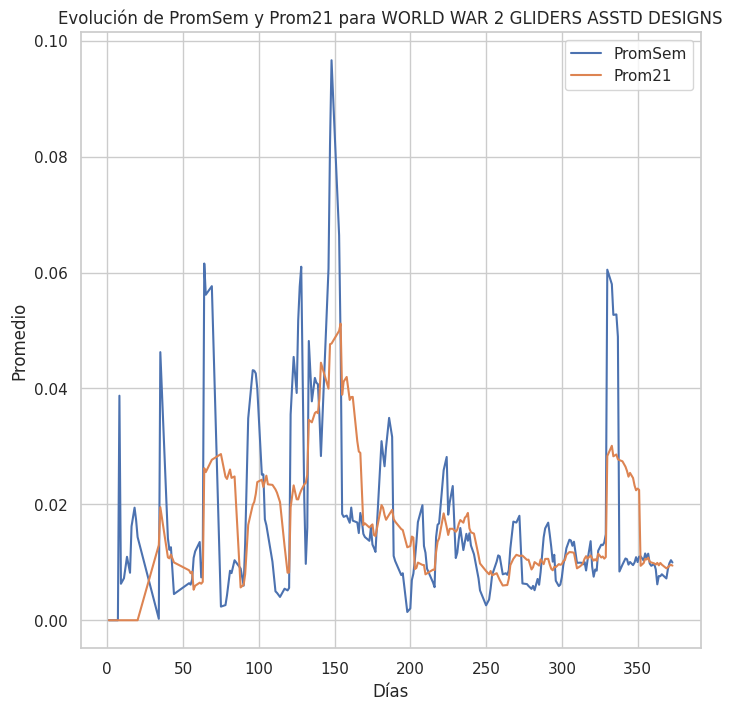

In [ ]:
df_producto = df[df['Description'] == 'WORLD WAR 2 GLIDERS ASSTD DESIGNS']
fig, ax = plt.subplots()
ax.plot(df_producto['Dias'], df_producto['PromSem'], label='PromSem')
ax.plot(df_producto['Dias'], df_producto['Prom21'], label='Prom21')
ax.set_xlabel('Días')
ax.set_ylabel('Promedio')
ax.set_title(f'Evolución de PromSem y Prom21 para WORLD WAR 2 GLIDERS ASSTD DESIGNS')
ax.legend()
plt.show()

**3. Filtros y Selección de atributos**

Dadas las pocas referencias que se tiene de datos fuera de UK y para mejorar las métricas, se decide realizar el modelo de predicción unicamente sobre las compras realizadas por UK, manteniendo un 91% de los datos

In [ ]:
antes = len(df)
df = df[df['Country'] == 'United Kingdom']
print(f'Porcentaje del df: {len(df)/antes}')
df = df.drop('Country', axis=1)

Porcentaje del df: 0.914564395018211


En la creación de Prom21, no se tiene datos históricos para incluir en esta columna sobre los primeros 20 días del dataset, por lo que se eliminan estas filas

In [ ]:
#Filtrado por columnas no incluidas en Prom21
df_filtrado = df[df['Prom21'] != 0]

Finalmente, al ser Quantity la variable target de nuestro modelo, y obteniendo métricas que no permitían realizar ningún acercamiento a la predicción; decidimos reducir al margen de Quantity.

Es importante destacar que:
- El Quantity máximo del dataset es 4800.
- Luego del filtrado, solamente se pierden un 1,8% de las filas.
- Es decir, solamente el 1,5% de las filas (45000 aprox) contenian valores de Quantity entre 100 y 4800.

In [ ]:
df_filtrado = df_filtrado[df_filtrado['Quantity'] < 100]
print(f'Porcentaje df_filtrado - df: {len(df_filtrado)/antes}')

Porcentaje df_filtrado - df: 0.8359742265795937


In [ ]:
df = df_filtrado

- Se eliminan columas que no aportan al modelo.

In [ ]:
# NECESARIO SACAR - LineTotal = UnitePrice * Quantity
df = df.drop('LineTotal', axis=1)

In [ ]:
# Contiene Nan
df = df.drop('CustomerID', axis=1)

In [ ]:
# Los productos se harán OneHot
df = df.drop('ProductId', axis=1)

In [ ]:
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249494 entries, 0 to 249493
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Unnamed: 0        249494 non-null  int64         
 1   InvoiceNo         249494 non-null  int64         
 2   Description       249494 non-null  object        
 3   Quantity          249494 non-null  int64         
 4   UnitPrice         249494 non-null  float64       
 5   InvoiceFecha      249494 non-null  datetime64[ns]
 6   InvoiceDiaSemana  249494 non-null  int64         
 7   Hora              249494 non-null  int64         
 8   Category          249494 non-null  object        
 9   TotalQuantity     249494 non-null  int64         
 10  TotalAmount       249494 non-null  float64       
 11  Dias              249494 non-null  int64         
 12  PromSem           249494 non-null  float64       
 13  Prom21            249494 non-null  float64       
dtypes: d

ONE HOT ENCODER
*   Category
*   Description\
Si bien es importante mencionar que el modelo finalmente utilizado acepta datos categóricos, mejora la performance del mismo y sus métricas, trabajar estas categorías como columnas.

In [ ]:
#One-Hot Encoding para convertir Category a columnas
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoded_countries = encoder.fit_transform(df['Category'].values.reshape(-1, 1))
df_encoded = pd.DataFrame(
    encoded_countries,
    columns=encoder.get_feature_names_out(),
)
df = pd.concat([df, df_encoded], axis=1)
df = df.drop('Category', axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249494 entries, 0 to 249493
Data columns (total 30 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Unnamed: 0               249494 non-null  int64         
 1   InvoiceNo                249494 non-null  int64         
 2   Description              249494 non-null  object        
 3   Quantity                 249494 non-null  int64         
 4   UnitPrice                249494 non-null  float64       
 5   InvoiceFecha             249494 non-null  datetime64[ns]
 6   InvoiceDiaSemana         249494 non-null  int64         
 7   Hora                     249494 non-null  int64         
 8   TotalQuantity            249494 non-null  int64         
 9   TotalAmount              249494 non-null  float64       
 10  Dias                     249494 non-null  int64         
 11  PromSem                  249494 non-null  float64       
 12  Prom21          

In [ ]:
#One-Hot Encoding para convertir descripciones a columnas
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoded_desc = encoder.fit_transform(df['Description'].values.reshape(-1, 1))
df_encoded = pd.DataFrame(
    encoded_desc,
    columns=encoder.get_feature_names_out(),
)
df = pd.concat([df, df_encoded], axis=1)
df = df.drop('Description', axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249494 entries, 0 to 249493
Columns: 640 entries, Unnamed: 0 to x0_ZINC WILLIE WINKIE CANDLE STICK
dtypes: datetime64[ns](1), float64(632), int64(7)
memory usage: 1.2 GB


**4. Partición de datos**

Split en train y test.\
Es importante mencionar que en este caso el split se hace por fecha, buscando darle sentido a nuestro objetivo, es decir que teniendo los datos de enero a noviembre, se pueda predecir el final del año.\
La fecha se calcula para obtener una división 80% train 20% test.

In [ ]:
# Definir las fechas de división
train_end_date = pd.to_datetime('2011-11-5')

# Dividir el conjunto de datos en train, validation y test
train_df = df[df['InvoiceFecha'] <= train_end_date]
test_df = df[df['InvoiceFecha'] > train_end_date]

# Verificar el tamaño de cada conjunto
print("Tamaño del conjunto de entrenamiento:", len(train_df))
print("Tamaño del conjunto de prueba:", len(test_df))

print("Procentaje del conjunto de entrenamiento:", len(train_df)/(len(train_df)+len(test_df)))


Tamaño del conjunto de entrenamiento: 199370
Tamaño del conjunto de prueba: 50124
Procentaje del conjunto de entrenamiento: 0.7990973730831202


Se quita InvoiceFecha ya que el tipo datetime no es aceptada por el modelo.

In [ ]:
train_df = train_df.drop('InvoiceFecha', axis=1)
test_df = test_df.drop('InvoiceFecha', axis=1)

Sacamos la variable target

In [ ]:
X_train = train_df.drop(columns=['Quantity'])
y_train = train_df['Quantity']

X_test = test_df.drop(columns=['Quantity'])
y_test = test_df['Quantity']

**5. Estandarizar**

In [ ]:
scaler = StandardScaler()

column_names = X_train.columns.tolist()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Volvemos a convertir a df (scaler lo convierte a numpy array)
X_train = pd.DataFrame(X_train, columns=column_names)
X_test = pd.DataFrame(X_test, columns=column_names)

**6. Modelo**

Aquí se prueban diversos algortimos, todos de regresion y se elije el que logra las mejores métricas.\
Se utiliza por ejemplo LinearRegression, Ridge, Lasso, DecisionTreeRegressor y finalmente RandomForestRegressor, el cual utilizamos.\
RandomForestRegressor es un algoritmo de aprendizaje supervisado, y se basa en la combinación de varios modelos de árboles de decisión para mejorar la predicción y reducir el sobreajuste.
- Construye un "bosque" de arboles de decisión. Cada árbol se entrena en forma independiente utilizando muestras aleatorias de los datos y un subconjunto aleatorio de features.
- La predicción final se calcula con el promedio de las predicciones de todos los árboles.
- Estrategia divide and conquer, para identificar los puntos de división óptimos dentro de un árbol.

In [ ]:
metricas = {
    'MSE': metrics.make_scorer(metrics.mean_squared_error),
    'RMSE': metrics.make_scorer(lambda y_true, y_pred: metrics.mean_squared_error(y_true, y_pred, squared=False)),
    'R2': metrics.make_scorer(metrics.r2_score)
}

Las métricas anteriores son las utilizadas para evaluar nuestro modelo.\ MSE es el error cuadrático medio y RSME da una interpetación más sencilla ya que está en la misma unidad que la variable target.\
R2 coeficiente de determinación. Nos indica que tanta variación tiene la variable dependiente para ser predecida desde las independientes.

In [ ]:
model = RandomForestRegressor(random_state=42)

#param_grid = {
#    'max_depth': [3,5,7],
#    'min_samples_split': [2,4,6],
#    'min_samples_leaf': [3,5,7],
#    'n_estimators': [100, 150, 200]
#}

param_grid = {
    'max_depth': [5],
    'min_samples_split': [2],
    'min_samples_leaf': [3]
}

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring=metricas, refit='MSE')

Se realiza un grid search para obtener los mejores parámetros y poder utilizar TimeSeriesSplit para el entrenamiento teniendo en cuenta la temporalidad.

In [ ]:
#Mostramos el funcionamiento de TimeSeriesSplit
url_imagen = "https://i.stack.imgur.com/Q37Bn.png"
Image(url=url_imagen)

In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [5], 'min_samples_leaf': [3],
                         'min_samples_split': [2]},
             refit='MSE',
             scoring={'MSE': make_scorer(mean_squared_error),
                      'R2': make_scorer(r2_score),
                      'RMSE': make_scorer(<lambda>)})

In [ ]:
best_params = grid_search.best_params_
best_params

{'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2}

Métricas obtenidas:
- 'max_depth': 5,
- 'min_samples_leaf': 3,
- 'min_samples_split': 2,
- 'n_estimators': 100


In [ ]:
best_model = grid_search.best_estimator_

best_model.fit(X_train, y_train)

y_test_pred = best_model.predict(X_test)

print(f'MSE: {metrics.mean_squared_error(y_test, y_test_pred)}')
print(f'RMSE: {metrics.mean_squared_error(y_test, y_test_pred, squared=False)}')
print(f'R2: {metrics.r2_score(y_test, y_test_pred)}')

MSE: 95.801151393944
RMSE: 9.787806260543983
R2: 0.1404937150008505


Métricas obtenidas:\
MSE: 95.85611791180239\
RMSE: 9.790613765837277\
R2: 0.1400005678217573

**7. Visualización**

<Axes: >

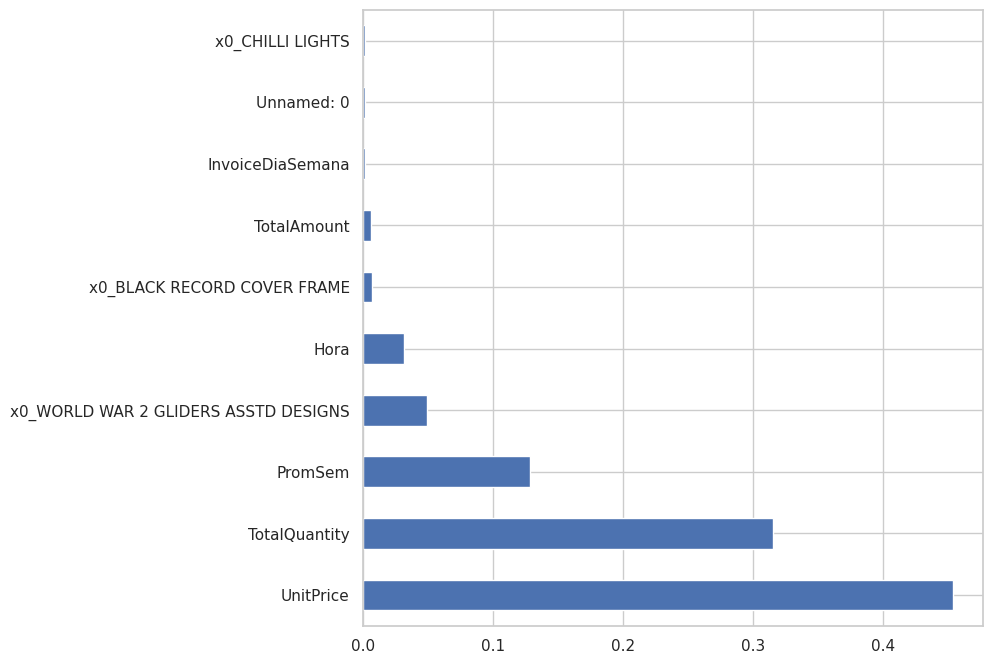

In [ ]:
feat_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

Es importante visualizar los features importances, aunque también se menciona que al reducir los features las métricas empeoran.

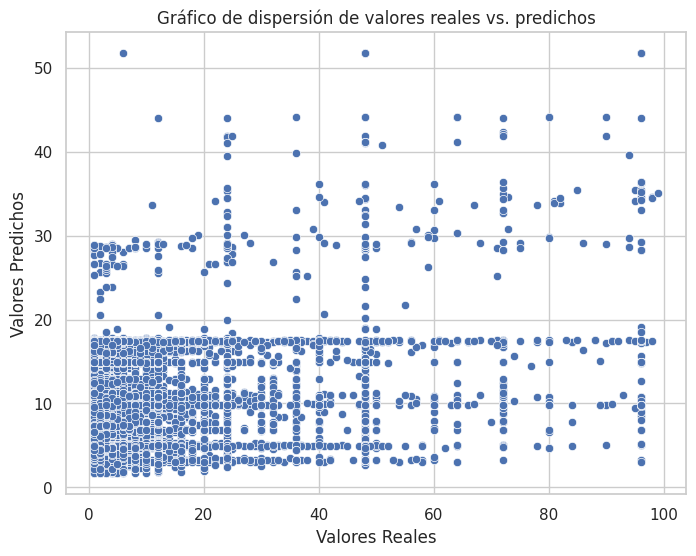

In [ ]:
# Gráfico de dispersión de valores reales vs. predichos
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_test_pred)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Gráfico de dispersión de valores reales vs. predichos')
plt.show()

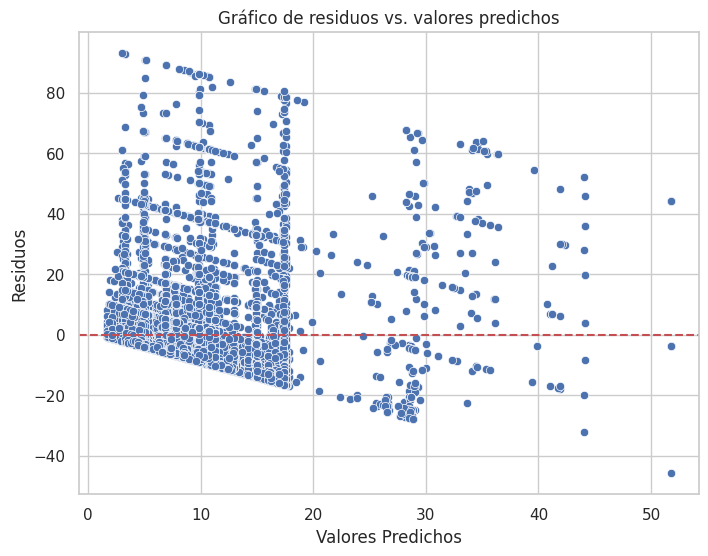

In [ ]:
# Gráfico de residuos vs. valores predichos
residuos = y_test - y_test_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_pred, y=residuos)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Gráfico de residuos vs. valores predichos')
plt.show()

**8. Exportación del modelo**

In [ ]:
# Exportar el modelo
joblib.dump(best_model, dirBase + "modelo_prediccion_ventas.pkl")

['/content/drive/MyDrive/Projecto_Senpai/EntregaFinal_Senpai/modelo_prediccion_ventas.pkl']

**9. Conclusiones**

No se logra obtener un modelo adecuado de regresion para predecir la cantidad de compras por pductos, algunas razones:
- El valor de R2 obtenido es muy cercano 0, lo que implica la poca relación entre las variables.
- El error RMSE es cercano a 10, en un entorno 0 a 100.
- No es posible limitar por productos ya que de los 610 productos 570 tienen alguna compra realizada de más de 100 unidades (el sector de datos excluído es representativo).
- Los modelos realizados para Quantity mayor a 100 tienen métricas menos alentadoras que éste.
- Los modelos realizados para los paises restantes, también carecen de datos suficientes para lograr un modelo adecuado.